In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors


make sure to rename the columns by removing é


# Exploratory Data Analysis (EDA) for Packages and Receptacle Datasets

In [138]:
# Load datasets
packages_df = pd.read_csv('../data/raw/packages_data_2023_2025.csv',delimiter=';', encoding='latin-1')
receptacles_df = pd.read_csv('../data/raw/receptacle_data_2023_2025.csv',delimiter=';', encoding='latin-1')

* Columns' names adjustment

In [139]:
packages_df = packages_df.rename(columns={'établissement_postal': 'etablissement_postal', 'next_établissement_postal': 'next_etablissement_postal'})
receptacles_df = receptacles_df.rename(columns={'ï»¿RECPTCL_FID': 'RECPTCL_FID', 'EVENT_TYPECD': 'EVENT_TYPE_CD', 'nextetablissement_postal': 'next_etablissement_postal'})

In [140]:
packages_df.shape, receptacles_df.shape

((1000000, 6), (1000000, 5))

* Columns' types adjustment

In [141]:
packages_df['date'] = pd.to_datetime(packages_df['date'])
receptacles_df['date'] = pd.to_datetime(receptacles_df['date'])
packages_df['RECPTCL_FID'] = packages_df['RECPTCL_FID'].str.strip()
packages_df['MAILITM_FID'] = packages_df['MAILITM_FID'].str.strip()
packages_df['etablissement_postal'] = packages_df['etablissement_postal'].str.strip()
packages_df['next_etablissement_postal'] = packages_df['next_etablissement_postal'].str.strip()
receptacles_df['etablissement_postal'] = receptacles_df['etablissement_postal'].str.strip()
receptacles_df['next_etablissement_postal'] = receptacles_df['next_etablissement_postal'].str.strip()
receptacles_df['RECPTCL_FID'] = receptacles_df['RECPTCL_FID'].str.strip()

In [142]:
packages_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   MAILITM_FID                1000000 non-null  object        
 2   date                       1000000 non-null  datetime64[ns]
 3   etablissement_postal       973228 non-null   object        
 4   EVENT_TYPE_CD              1000000 non-null  int64         
 5   next_etablissement_postal  411733 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 45.8+ MB


In [143]:
receptacles_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   date                       1000000 non-null  datetime64[ns]
 2   etablissement_postal       998889 non-null   object        
 3   EVENT_TYPE_CD              1000000 non-null  int64         
 4   next_etablissement_postal  576148 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 38.1+ MB


In [144]:
packages_df.head(n=5)

,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,USORDADZALGDAUN30050001900005,0000420016941,2023-07-04 05:00:00,NaN,12,ETAB_2389
1,USORDADZALGDAUN30050001900005,0000689914049,2023-07-04 05:00:00,NaN,12,ETAB_2389
2,USORDADZALGDAUN30050001900005,0000700051000,2023-07-04 05:00:00,NaN,12,ETAB_2389
3,USORDADZALGDAUN30102003900026,0031069949200,2023-12-04 05:00:00,NaN,12,ETAB_2389
4,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389


In [145]:
receptacles_df.head(n=5)

,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,NaN
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033
4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030


 Initial Observations
- both datasets cover the period from 2023 to 2025
- we have no target variable in either dataset
- for packages dataset:
    - 6 features in total with 5 categorical and 1 numerical
    - MAILITM_FID is unique identifier for each package
    - RECPTCL_FID is foreign key linking to receptacle dataset
    - etablissement_postal and next_etablissement_postal have some null values
- for receptacle dataset:
    - 5 features in total with 4 categorical and 1 numerical
    - RECPTCL_FID is unique identifier for each receptacle
    - EVENT_TYPE_CD has some null values

In [146]:
for column in packages_df.columns:
    print(f'{column} has {packages_df[column].nunique()} unique values.')
    print(f'{column} has {packages_df[column].isnull().sum()} null values.')
    print("\n")


RECPTCL_FID has 45306 unique values.
RECPTCL_FID has 0 null values.


MAILITM_FID has 109220 unique values.
MAILITM_FID has 0 null values.


date has 849213 unique values.
date has 0 null values.


etablissement_postal has 2825 unique values.
etablissement_postal has 26772 null values.


EVENT_TYPE_CD has 24 unique values.
EVENT_TYPE_CD has 0 null values.


next_etablissement_postal has 2716 unique values.
next_etablissement_postal has 588267 null values.




In [147]:
for column in receptacles_df.columns:
    print(f'{column} has {receptacles_df[column].nunique()} unique values.')
    print(f'{column} has {receptacles_df[column].isnull().sum()} null values.')
    print("\n")

RECPTCL_FID has 215867 unique values.
RECPTCL_FID has 0 null values.


date has 694907 unique values.
date has 0 null values.


etablissement_postal has 50 unique values.
etablissement_postal has 1111 null values.


EVENT_TYPE_CD has 17 unique values.
EVENT_TYPE_CD has 0 null values.


next_etablissement_postal has 9 unique values.
next_etablissement_postal has 423852 null values.




we notice the following:<br>
- receptacle dataset has more unique values for RECPTCL_FID than packages dataset, indicating one-to-many relationship<br>
- MAILITM_FID is unique in packages dataset.<br>
- packages dataset have more unique date values than receptacle dataset.<br>
- both datasets have null values in etablissement_postal and next_etablissement_postal columns. This requires processing later on<br>
- packages dataset has more unique values in the next_etablissement_postal column compared to receptacle dataset but also more null values. **further investigation is needed to understand why**<br>


In [148]:
packages_df.describe()

,date,EVENT_TYPE_CD
count,1000000,1000000.000000
mean,2024-04-09 07:24:35.733279488,27.271583
min,2020-02-01 09:22:30.150000,1.000000
25%,2023-08-30 09:47:12.600000,30.000000
50%,2024-04-30 07:12:00.241500160,32.000000
75%,2024-11-23 07:37:32.470500096,36.000000
max,2025-03-20 22:45:00,73.000000
std,NaN,12.326209


In [149]:
receptacles_df.describe()

,date,EVENT_TYPE_CD
count,1000000,1000000.000000
mean,2024-01-09 12:36:06.106905088,130.512065
min,2022-12-15 02:59:00,100.000000
25%,2023-05-31 09:15:37.029250048,107.000000
50%,2023-12-27 21:48:30,131.000000
75%,2024-08-05 11:27:24.005250048,132.000000
max,2025-03-21 15:15:00,178.000000
std,NaN,22.059407


for EVENT_TYPE_CD we notice different range of values for packages and receptacle datasets indicating different types of events.<br>

#### Visualizations
for now we will visualize the distribution of EVENT_TYPE_CD in both datasets.<br>



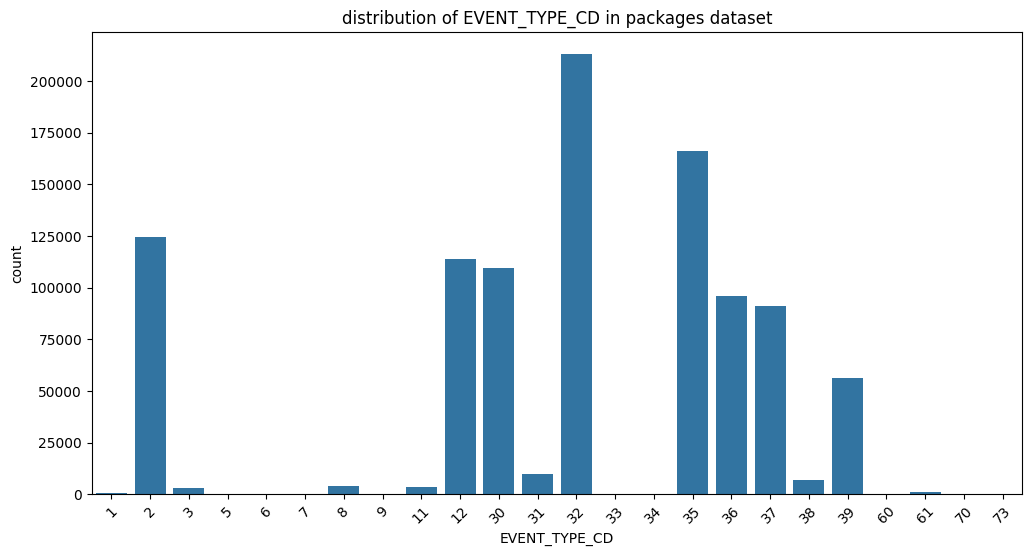

In [150]:
# Distribution of EVENT_TYPE_CD in packages dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=packages_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in packages dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

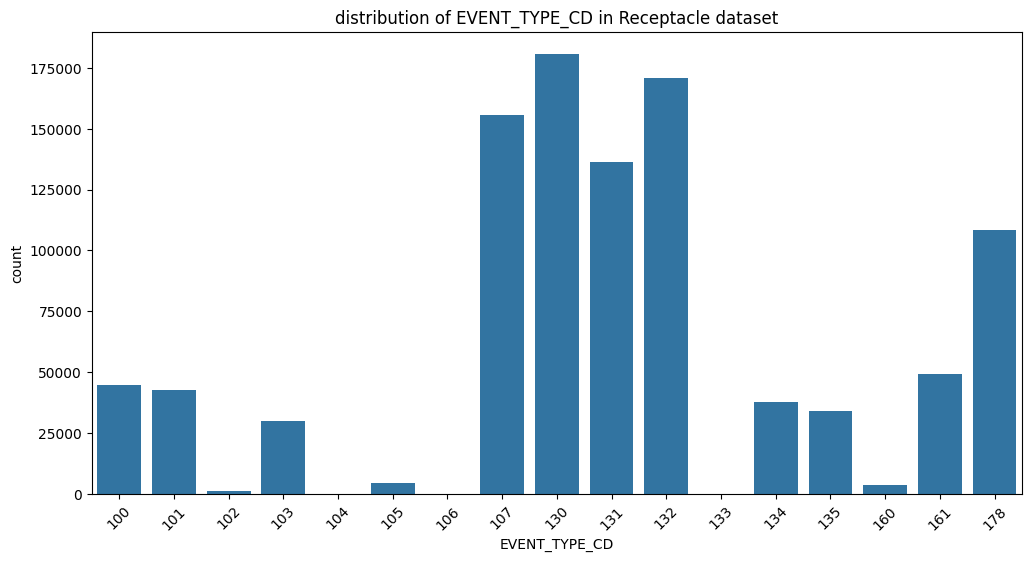

In [151]:
# Distribution of EVENT_TYPE_CD in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacles_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in Receptacle dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

for etablissement_postal and next_etablissement_postal I will start with visualizing the receptacle dataset since the packages dataset has a lot of unique values<br>

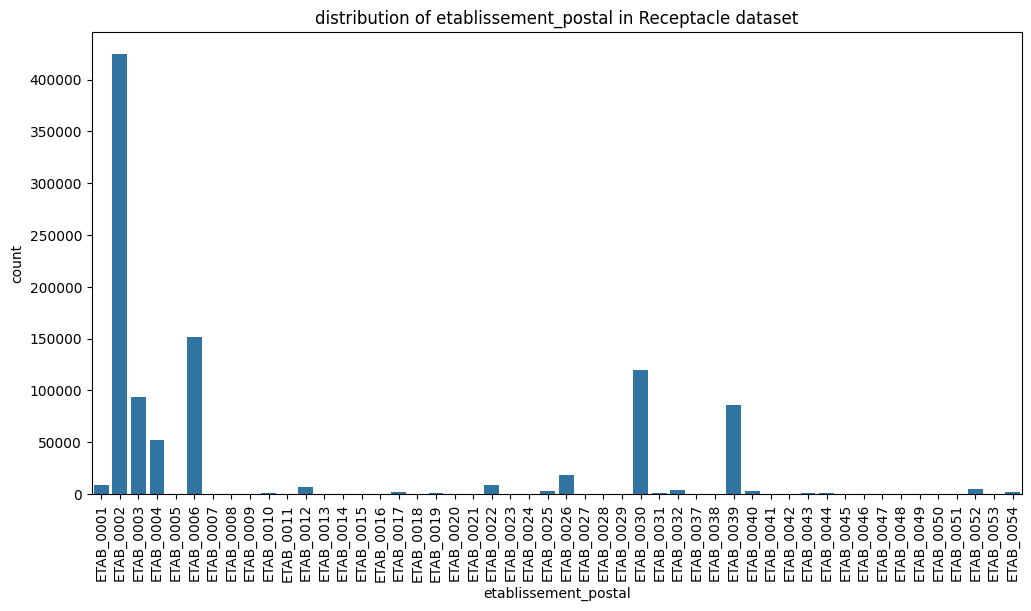

In [152]:
# Distribution of etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacles_df,x='etablissement_postal')
plt.title('distribution of etablissement_postal in Receptacle dataset')
plt.xlabel('etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()


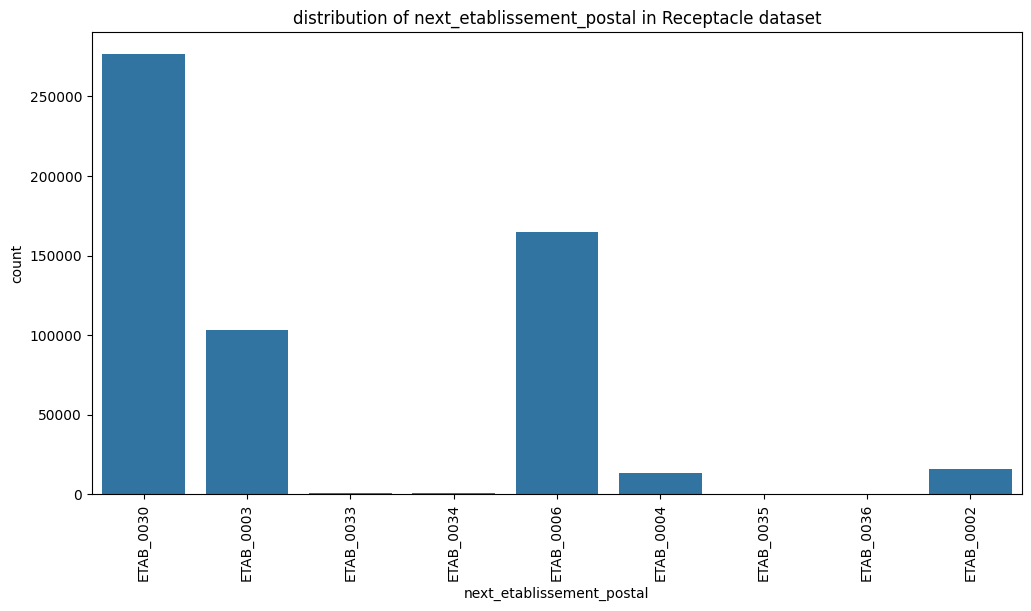

In [153]:
# Distribution of next_etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacles_df,x='next_etablissement_postal')
plt.title('distribution of next_etablissement_postal in Receptacle dataset')
plt.xlabel('next_etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

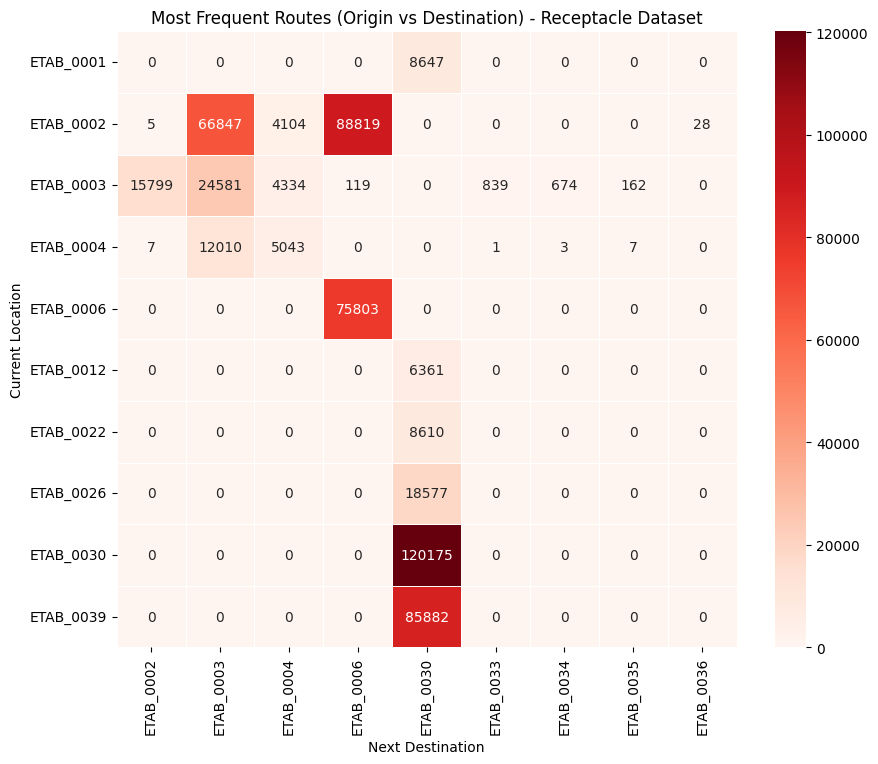

In [154]:
# 1.  Top 10 locations to keep the map small
top_locs = receptacles_df['etablissement_postal'].value_counts().head(10).index
top_next = receptacles_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = receptacles_df[
    (receptacles_df['etablissement_postal'].isin(top_locs)) &
    (receptacles_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Receptacle Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

we notice that some etablissements have significantly higher traffic compared to others, indicating  major distribution centers.<br>

for etablissement_postal and next_etablissement_postal we will create a heatmap to visualize the flow between current location and next destination.<br>
Count of parcels moving from A to B to see the density of connections between them

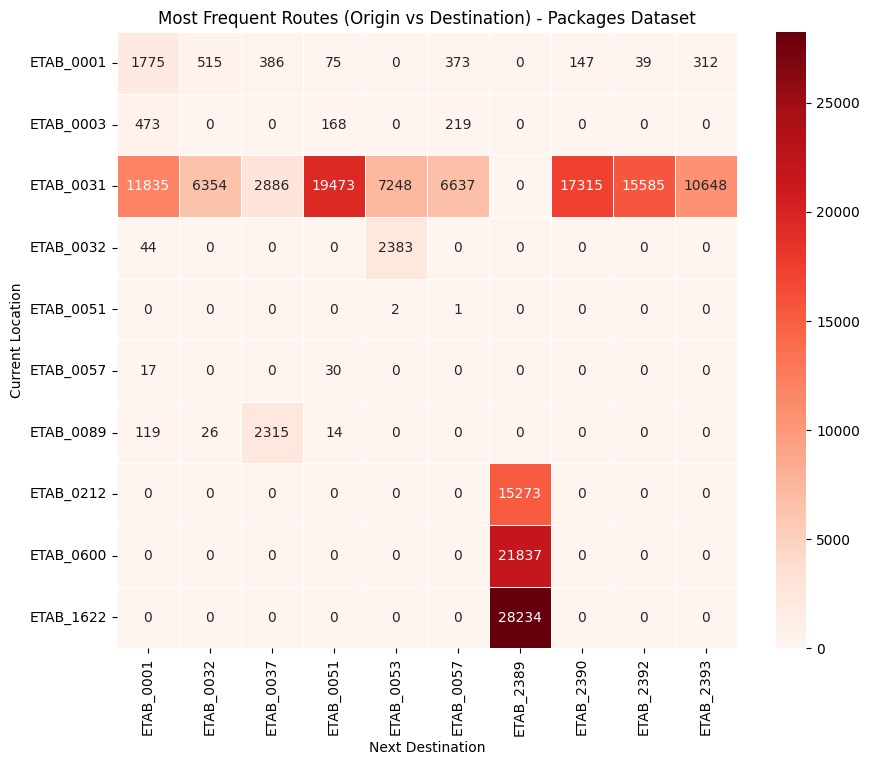

In [155]:
# 1.  Top 10 locations to keep the map small
top_locs = packages_df['etablissement_postal'].value_counts().head(10).index
top_next = packages_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = packages_df[
    (packages_df['etablissement_postal'].isin(top_locs)) &
    (packages_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Packages Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\2799116581.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Volume', y='Location', data=location_counts.head(20), palette='viridis')


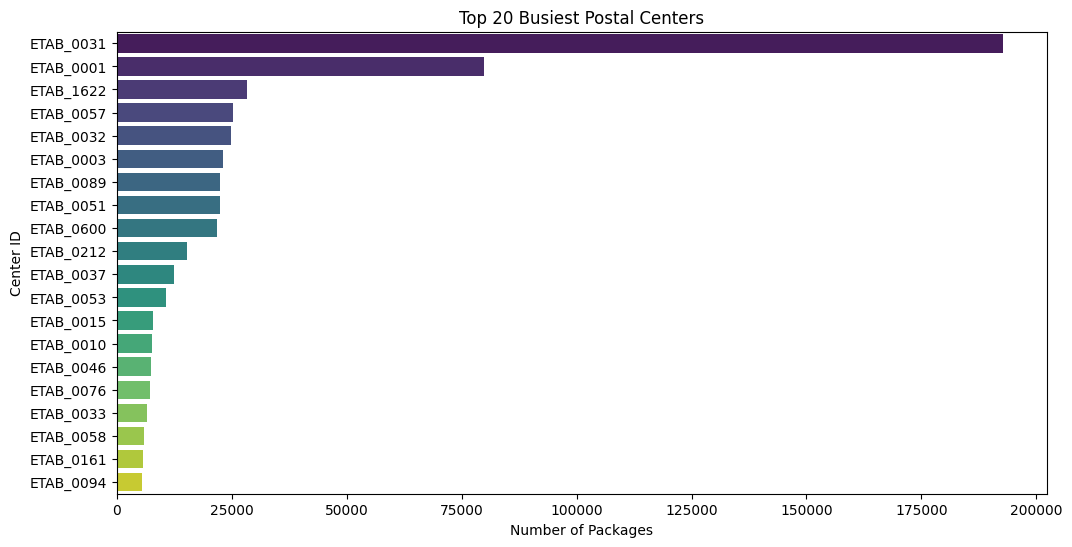

In [156]:
# Count packages per location
location_counts = packages_df['etablissement_postal'].value_counts().reset_index()
location_counts.columns = ['Location', 'Volume']

# keep only top 20 busiest centers
plt.figure(figsize=(12, 6))
sns.barplot(x='Volume', y='Location', data=location_counts.head(20), palette='viridis')
plt.title("Top 20 Busiest Postal Centers")
plt.xlabel("Number of Packages")
plt.ylabel("Center ID")
plt.show()

we notice the same pattern as before with some etablissements having significantly higher trafic compared to others.<br>

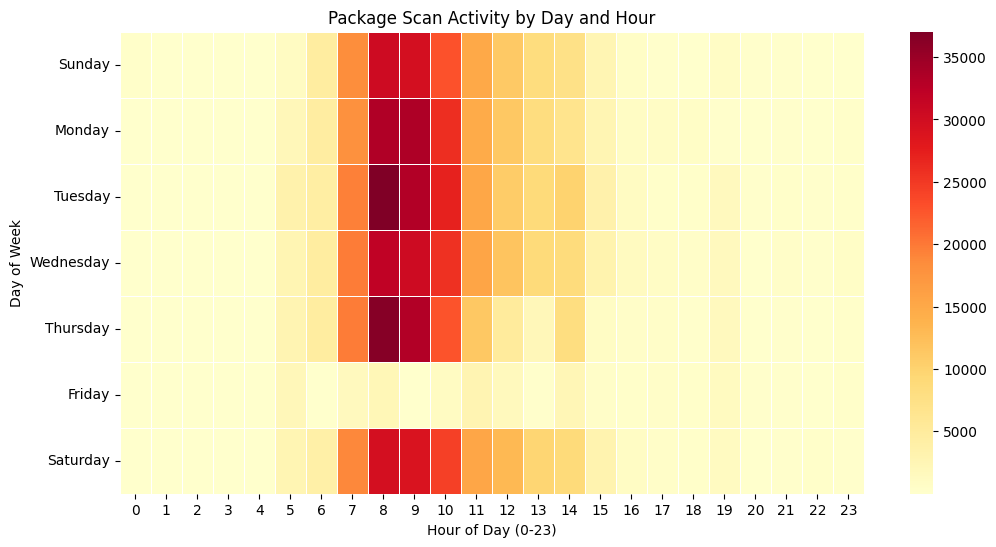

In [157]:

# 1. Extract Time Features
packages_df['hour'] = packages_df['date'].dt.hour
packages_df['day_of_week'] = packages_df['date'].dt.day_name()

# 2. Create a Pivot Table (Cross-tabulation)
# Rows = Day, Cols = Hour, Values = Count of Scans
heatmap_data = pd.crosstab(
    packages_df['day_of_week'],
    packages_df['hour']
)

days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
heatmap_data = heatmap_data.reindex(days_order)

# 3. Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=.5, annot=False)
plt.title("Package Scan Activity by Day and Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Day of Week")
plt.show()

we notice that the busiest times for package scans are during weekdays, particularly from mid-morning to late afternoon.<br>

In [158]:
#number of packages per receptacle
packages_per_receptacle = packages_df.groupby('RECPTCL_FID')['MAILITM_FID'].nunique()
packages_per_receptacle.head()


RECPTCL_FID
AEDXBADZAAEDACN45001001100219    20
AEDXBADZAAEDACN45002001100075     9
AEDXBADZAAEDACN45003001100123    15
AEDXBADZAAEDACN45004001100073     5
AEDXBADZAAEDACN45005001100107     9
Name: MAILITM_FID, dtype: int64

# Preprocessing

In [159]:
packages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   MAILITM_FID                1000000 non-null  object        
 2   date                       1000000 non-null  datetime64[ns]
 3   etablissement_postal       973228 non-null   object        
 4   EVENT_TYPE_CD              1000000 non-null  int64         
 5   next_etablissement_postal  411733 non-null   object        
 6   hour                       1000000 non-null  int32         
 7   day_of_week                1000000 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 57.2+ MB


In [160]:
receptacles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   date                       1000000 non-null  datetime64[ns]
 2   etablissement_postal       998889 non-null   object        
 3   EVENT_TYPE_CD              1000000 non-null  int64         
 4   next_etablissement_postal  576148 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 38.1+ MB


In [161]:
packages_df['etablissement_postal'].isna().sum()

np.int64(26772)

* `etablissement_postal` have 26772 null values (2.7% of the whole dataset)
* As its null values are less than 5% of the dataset (2.7%), we drop these null values

In [162]:
packages_df = packages_df[~packages_df['etablissement_postal'].isna()]
packages_df['etablissement_postal'].isna().sum()

np.int64(0)

* We propose to consider the packages having null `next_etablissement_postal`
as having issue during transfer, we'll try to validate that using
`EVENT_TYPE_CD` also
* Let's check if `EVENT_TYPE_CD` can indicate whether the `next_etablissement_postal` is null or not

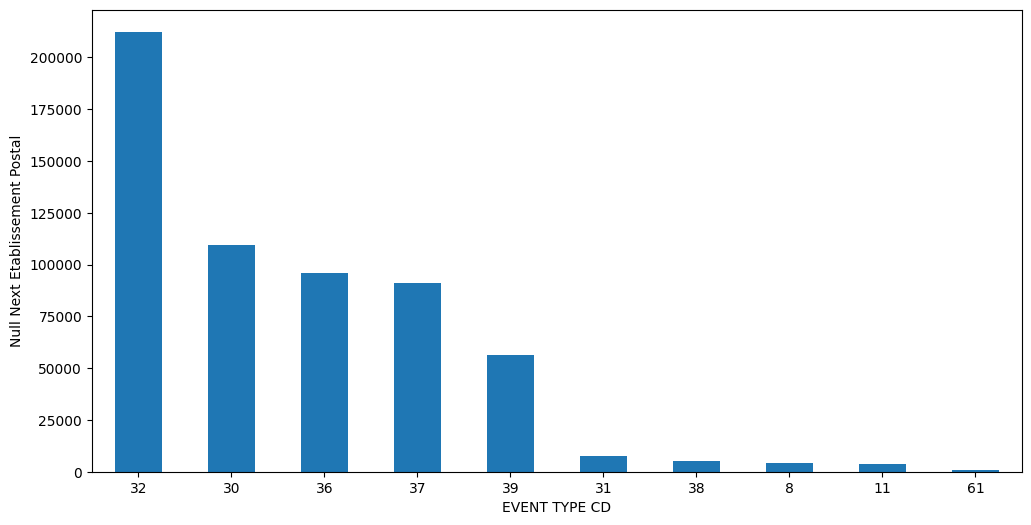

In [163]:
packages_unknown_next_etablissement = packages_df[packages_df['next_etablissement_postal'].isna()]
# keep only top EVENT_TYPES_ID
packages_unknown_next_etablissement = packages_unknown_next_etablissement['EVENT_TYPE_CD'].value_counts()

plt.figure(figsize=(12, 6))
packages_unknown_next_etablissement.head(10).plot(kind='bar')
plt.xlabel('EVENT TYPE CD')
plt.ylabel('Null Next Etablissement Postal')
plt.xticks(rotation=0)
plt.show()

* `EVENT_TYPE_CD` doesn't actually indicate null values of `next_etablissement_postal`

* the function `fill_NaN_next_etab` cell fills the `next_etablissement_postal` using the next `etablissement_postal` for the same package.
* if the last route for a specific package is null, then it keeps it null because there's no next `etablissement_postal` for that package.

In [164]:
def fill_NaN_next_etab(df, id_col):
    # 1. Ensure the dataframe is sorted (same as before)
    df = df.sort_values([id_col, 'date'])

    # 2. Look ahead to the next row's postal code and ID
    shifted_postal = df['etablissement_postal'].shift(-1)
    shifted_id = df[id_col].shift(-1)
# 3. Identify the "boundaries" where the postal code changes within the same package
# This marks the last row of a block with the value of the start of the next block
    is_boundary = (df['etablissement_postal'] != shifted_postal) & \
              (df[id_col] == shifted_id)
# 4. Use grouped backfill to broadcast those values to all preceding rows in the block
# This replaces your 'blocks.map' logic with a single vectorized pass
    fill_values = shifted_postal.where(is_boundary).groupby(df[id_col]).bfill()

# 5. Fill only the NaNs in the existing column to match your original logic
    df['next_etablissement_postal'] = df['next_etablissement_postal'].fillna(fill_values)
    
    return df

In [165]:
# Apply the function to fill NaN values in next_etablissement_postal
packages_df = fill_NaN_next_etab(packages_df, 'MAILITM_FID')
# Check remaining NaNs
packages_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 973228 entries, 35 to 950829
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RECPTCL_FID                973228 non-null  object        
 1   MAILITM_FID                973228 non-null  object        
 2   date                       973228 non-null  datetime64[ns]
 3   etablissement_postal       973228 non-null  object        
 4   EVENT_TYPE_CD              973228 non-null  int64         
 5   next_etablissement_postal  644430 non-null  object        
 6   hour                       973228 non-null  int32         
 7   day_of_week                973228 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 63.1+ MB


* Like this, we've handled a good part of null values and inconsitencies for `packages` dataset.

* **We'll be doing the same steps for `receptacle` dataset**

In [166]:
receptacles_df['etablissement_postal'].isna().sum()

np.int64(1111)

* Dropping rows having null `etablissement_postal`, as they're just 0.1% of the data

In [167]:
receptacles_df = receptacles_df[~receptacles_df['etablissement_postal'].isna()]
receptacles_df['etablissement_postal'].isna().sum()

np.int64(0)

* apply the function that fills null values of `next_etablissement_postal` using `etablissement_postal` to `receptacles_df`

In [168]:
receptacles_df = fill_NaN_next_etab(receptacles_df, 'RECPTCL_FID')
# Check remaining NaNs
receptacles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998889 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RECPTCL_FID                998889 non-null  object        
 1   date                       998889 non-null  datetime64[ns]
 2   etablissement_postal       998889 non-null  object        
 3   EVENT_TYPE_CD              998889 non-null  int64         
 4   next_etablissement_postal  910392 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 45.7+ MB


* Null values are mostly gone, but there are still some illogical packages' and receptacles' routes between `etablissements`
* We'll treat these logical routes now

In [169]:
# for each package (group of rows), check whether there's any illogical route
# between 'etablissement_postal' and 'next_etablissement_postal'
def isPackageIllogical(group):
    return (
        group['next_etablissement_postal']
        .iloc[:-1]
        .ne(group['etablissement_postal'].shift(-1).iloc[:-1])
        .any()
    )

In [170]:
illogical_packages = packages_df.groupby('MAILITM_FID').apply(isPackageIllogical)
illogical_packages.value_counts()

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\1525254997.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  illogical_packages = packages_df.groupby('MAILITM_FID').apply(isPackageIllogical)


True     103376
False      3236
Name: count, dtype: int64

In [171]:
103376 / packages_df['MAILITM_FID'].nunique()

0.9696469440588301

* 103376 Packages have illogical routes (98%) of all packages, so it's impossible to drop them, but instead, we plan to ignore the `MAILITM_FID` and `RECPTCL_FID` in the training and testing sets that will come next

In [172]:
# for each receptacle (group of rows), check whether there's any illogical route
# between 'etablissement_postal' and 'next_etablissement_postal'
def isReceptacleIllogical(group):
    return (
        group['next_etablissement_postal']
        .iloc[:-1]
        .ne(group['etablissement_postal'].shift(-1).iloc[:-1])
        .any()
    )

In [173]:
illogical_receptacles = receptacles_df.groupby('RECPTCL_FID').apply(isReceptacleIllogical)
illogical_receptacles.value_counts()

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\126394579.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  illogical_receptacles = receptacles_df.groupby('RECPTCL_FID').apply(isReceptacleIllogical)


True     205519
False     10326
Name: count, dtype: int64

In [174]:
205519 / receptacles_df['RECPTCL_FID'].nunique()

0.9521601148972643

205519 receptacles have illogical routes (95%) of all receptacles, so it's also impossible to drop them

In [175]:
# keep copies for backup (en cas ou)
packages_df_copy = packages_df.copy()
receptacles_df_copy = receptacles_df.copy()

# Feature Extraction 

### Check RECPTCL_FID and MAILITM_FID having same length formats
if yes then we can split them into meaningfull parts

In [176]:
same=1
print("\n=== RECPTCL_FID  ===")
print(f"testing if the lengths of RECPTCL_FID values are all the same:")
for val in packages_df['RECPTCL_FID'].values:
    if len(str(val)) != 29 :
        print(f"  {val} (length: {len(str(val))})")
        same=0
        break
if same==1:
    print('all same length' )

print("\n=== MAILITM_FID  ===")
print(f"testing if the lengths of MAILITM_FID values are all the same:")
for val in packages_df['MAILITM_FID'].values:
    if len(str(val)) != 13 :
        print(f"  {val} (length: {len(str(val))})")
        same=0
        break
if same==1:
    print ('all same length' )




=== RECPTCL_FID  ===
testing if the lengths of RECPTCL_FID values are all the same:
all same length

=== MAILITM_FID  ===
testing if the lengths of MAILITM_FID values are all the same:
all same length


### RECPTCL_FID Analysis
- **Format:** 29-character string (e.g., `USORDADZALGDAUN30050001900005`)
- **Data Quality:** No null values (1,000,000) | 215,867 unique values in receptacle dataset and 45306 unique values in packages dataset
- **Extractable Features:**
  - Origin Country (2 chars): US, FR, AE, etc.
  - Destination Country (2 chars): DZ, AI, AA, etc.

### MAILITM_FID Analysis
- **Format:** 13-character string according to the S10-12 patern (e.g., `CA000132868US`, `CA000340856PK`)
- **Data Quality:** No null values (1,000,000 packages)
- **Extractable Features:**
  - Service Indicator (2 chars): CA, etc.
  - Serial Number (8 chars): 00013286, 00034085, etc.
  - Check Digit (1 char): 8, 6, etc.
  - Country Code (3 chars, right-stripped): US, PK.


## Definition of the parser funtions
These functions are responsible for spliting the IDs into parts

In [177]:
def parse_recptcl_fid(id_str):
    origin_country = id_str[0:2]
    destination_country = id_str[6:8]
    return origin_country, destination_country

def parse_mailitm_fid(id_str):
    service_indicator = id_str[0:2]
    serial_number = id_str[2:11]
    country_code = id_str[11:14].strip()
    return service_indicator, serial_number, country_code


### Apply parsing functions

In [178]:
# parsed_receptacles_df = receptacles_df.copy()
# parsed_receptacles_df[['origin_country', 'destination_country']] = parsed_receptacles_df['RECPTCL_FID'].apply(lambda x: pd.Series(parse_recptcl_fid(x)))

# Faster method:
parsed_data = list(receptacles_df['RECPTCL_FID'].apply(parse_recptcl_fid))

# Assign to new columns by creating a temporary DataFrame
parsed_receptacles_df = receptacles_df.copy()
parsed_receptacles_df[['origin_country', 'destination_country']] = pd.DataFrame(
    parsed_data, index=receptacles_df.index
)

In [179]:
# parsed_packages_df = packages_df.copy()
# parsed_packages_df[['service_indicator', 'serial_number', 'country_code']] = parsed_packages_df['MAILITM_FID'].apply(lambda x: pd.Series(parse_mailitm_fid(x)))
# parsed_packages_df[['origin_country','destination_country']] = parsed_packages_df['RECPTCL_FID'].apply(lambda x: pd.Series(parse_recptcl_fid(x)))

# Faster method:
parsed_packages_df = packages_df.copy()

# 1. Optimize MAILITM_FID parsing
mailitm_data = list(parsed_packages_df['MAILITM_FID'].apply(parse_mailitm_fid))
parsed_packages_df[['service_indicator', 'serial_number', 'country_code']] = pd.DataFrame(
    mailitm_data, index=parsed_packages_df.index
)

# 2. Optimize RECPTCL_FID parsing
recptcl_data = list(parsed_packages_df['RECPTCL_FID'].apply(parse_recptcl_fid))
parsed_packages_df[['origin_country', 'destination_country']] = pd.DataFrame(
    recptcl_data, index=parsed_packages_df.index
)

### show samples of new parsed data

In [180]:

print("=== packages_df sample with new parsed columns ===")
parsed_packages_df.head()



=== packages_df sample with new parsed columns ===


,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal,hour,day_of_week,service_indicator,serial_number,country_code,origin_country,destination_country
35,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-13 07:19:09.307,ETAB_0001,30,ETAB_0002,7,Monday,1A,195194037,83,FR,DZ
36,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:21:30.137,ETAB_0002,32,NaN,7,Tuesday,1A,195194037,83,FR,DZ
37,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:22:52.407,ETAB_0002,36,NaN,7,Tuesday,1A,195194037,83,FR,DZ
38,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 07:23:59.220,ETAB_0002,39,NaN,7,Tuesday,1A,195194037,83,FR,DZ
39,FRCDGADZALGDAUN32090009010009,1A19519403783,2023-03-14 08:15:50.470,ETAB_0002,39,NaN,8,Tuesday,1A,195194037,83,FR,DZ


In [181]:
print("\n=== receptacles_df sample with new parsed columns ===")
parsed_receptacles_df.head()


=== receptacles_df sample with new parsed columns ===


,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal,origin_country,destination_country
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030,AE,DZ
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,ETAB_0003,AE,DZ
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003,AE,DZ
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033,AE,DZ
4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030,AE,DZ


# Analysis of the extrcted features


## 1. parsed_packages_df

In [182]:

print("\n--- Unique Value Counts for parsed_packages_df ---")
print("\nFor receptacle FID parsing:")
print(f"Unique origin_country values: {parsed_packages_df['origin_country'].nunique()}")
print(f"Unique destination_country values: {parsed_packages_df['destination_country'].nunique()}")

print("="*50)
print("\nFor mail item FID parsing:")
print(f"Unique service_indicator values: {parsed_packages_df['service_indicator'].nunique()}")
print(f"Unique country_code values: {parsed_packages_df['country_code'].nunique()}")




--- Unique Value Counts for parsed_packages_df ---

For receptacle FID parsing:
Unique origin_country values: 64
Unique destination_country values: 1

For mail item FID parsing:
Unique service_indicator values: 66
Unique country_code values: 121


## 2. parsed_receptacles_df 

In [183]:
print("\n--- Unique Value Counts for parsed_receptacles_df ---")
print(f"Unique origin_country values: {parsed_receptacles_df['origin_country'].nunique()}")
print(f"Unique destination_country values: {parsed_receptacles_df['destination_country'].nunique()}")



--- Unique Value Counts for parsed_receptacles_df ---
Unique origin_country values: 49
Unique destination_country values: 79


## List values of the new columns obtained from receptacle FID parsing for both parsed dataframes

### 1. for parsed_packages_df

In [184]:
#listing the values 
print("\n--- Values of origin_country ---")
print(parsed_packages_df['origin_country'].unique())

print("\n--- Values of destination_country ---")
print(parsed_packages_df['destination_country'].unique())



--- Values of origin_country ---
['FR' 'CH' 'MA' 'US' 'BE' 'TG' 'PK' 'RU' 'GR' 'JE' 'CI' 'PT' 'TN' 'AT'
 'AR' 'KR' 'DE' 'JP' 'TR' 'OM' 'AZ' 'NL' 'UA' 'MD' 'AE' 'ES' 'BG' 'GB'
 'IT' 'SE' 'CA' 'NG' 'HU' 'NZ' 'AM' 'DK' 'CZ' 'SA' 'FI' 'CN' 'LT' 'HK'
 'TH' 'ID' 'IE' 'PS' 'DJ' 'BJ' 'GE' 'BH' 'MR' 'IQ' 'LB' 'CU' 'VN' 'PL'
 'QA' 'JO' 'MY' 'MV' 'MU' 'SG' 'KG' 'EG']

--- Values of destination_country ---
['DZ']


### 2. for parsed_receptacles_df

In [185]:
#listing the values 
print("\n--- Values of origin_country ---")
print(parsed_receptacles_df['origin_country'].unique())

print("\n--- Values of destination_country ---")
print(parsed_receptacles_df['destination_country'].unique())



--- Values of origin_country ---
['AE' 'AM' 'AR' 'AT' 'AU' 'AZ' 'BE' 'BF' 'BG' 'BH' 'BJ' 'BY' 'CA' 'CG'
 'CH' 'CI' 'CM' 'CN' 'CR' 'CU' 'CZ' 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EE' 'EG'
 'ES' 'ET' 'FI' 'FR' 'GB' 'GE' 'GI' 'GQ' 'GR' 'HK' 'HU' 'ID' 'IE' 'IN'
 'IQ' 'IR' 'IS' 'IT' 'JE' 'JO' 'JP']

--- Values of destination_country ---
['DZ' 'MU' 'NE' 'TN' 'NL' 'AE' 'KZ' 'AU' 'CL' 'AR' 'FR' 'JP' 'ES' 'DE'
 'KG' 'LY' 'ML' 'MR' 'QA' 'AT' 'BE' 'CA' 'CH' 'CN' 'CZ' 'EG' 'GB' 'GR'
 'HK' 'HU' 'IE' 'IN' 'IT' 'JO' 'KR' 'KW' 'MY' 'OM' 'PL' 'PS' 'PT' 'RO'
 'RU' 'SA' 'SE' 'SG' 'TR' 'US' 'UZ' 'AL' 'AO' 'BR' 'CI' 'CM' 'CU' 'DK'
 'ET' 'FI' 'LB' 'MA' 'MG' 'NG' 'NO' 'PH' 'SD' 'SN' 'TW' 'BJ' 'BY' 'GF'
 'GP' 'MQ' 'MX' 'NZ' 'RE' 'TH' 'YT' 'ZA' 'BD']


### Do the intersection of origin_country of both dataframes

In [186]:
#do the intersection of origin_country values in both parsed datasets
packages_origin_countries = set(parsed_packages_df['origin_country'].unique())
receptacle_origin_countries = set(parsed_receptacles_df['origin_country'].unique())
common_origin_countries = packages_origin_countries.intersection(receptacle_origin_countries)
print("number of common origin_country values in both parsed datasets:", len(common_origin_countries))
print(f"\nCommon origin_country values in both paesed datasets: ")
print(common_origin_countries)
# remaining ones 
remaining_in_packages = packages_origin_countries - common_origin_countries
remaining_in_receptacle = receptacle_origin_countries - common_origin_countries
print(f"Remaining origin_country values only in parsed_packages_df:")
print(remaining_in_packages)
print(f"Remaining origin_country values only in parsed_receptacles_df:")
print(remaining_in_receptacle )

number of common origin_country values in both parsed datasets: 34

Common origin_country values in both paesed datasets: 
{'EG', 'HU', 'DK', 'ES', 'DJ', 'DE', 'IT', 'GE', 'CU', 'CI', 'JO', 'CA', 'JE', 'AE', 'AT', 'AZ', 'AR', 'IQ', 'BE', 'CN', 'BH', 'ID', 'GB', 'FI', 'CZ', 'FR', 'IE', 'BG', 'GR', 'AM', 'CH', 'JP', 'BJ', 'HK'}
Remaining origin_country values only in parsed_packages_df:
{'MV', 'PS', 'TH', 'MU', 'KR', 'SA', 'RU', 'PL', 'US', 'SG', 'PK', 'OM', 'LT', 'NZ', 'MY', 'TN', 'NL', 'PT', 'TG', 'TR', 'QA', 'NG', 'UA', 'MA', 'MR', 'MD', 'KG', 'VN', 'LB', 'SE'}
Remaining origin_country values only in parsed_receptacles_df:
{'ET', 'CG', 'DO', 'CM', 'IS', 'GQ', 'IR', 'IN', 'GI', 'DZ', 'CR', 'EE', 'AU', 'BF', 'BY'}


### list the values of both service indicators and country code

### 1. service indicators

In [187]:
print("\n--- Values of service_indicator ---")
print(parsed_packages_df['service_indicator'].unique())




--- Values of service_indicator ---
['1A' '2C' '2D' '2K' '3C' 'AP' 'AR' 'AS' 'BC' 'CA' 'CB' 'CC' 'CD' 'CE'
 'CF' 'CG' 'CH' 'CI' 'CJ' 'CK' 'CL' 'CM' 'CN' 'CO' 'CP' 'CQ' 'CR' 'CS'
 'CT' 'CU' 'CV' 'CW' 'CX' 'CY' 'CZ' 'Co' 'Cs' 'DZ' 'LA' 'LB' 'LC' 'LD'
 'LE' 'LF' 'LG' 'LH' 'LI' 'LJ' 'LK' 'LL' 'LM' 'LN' 'LP' 'LR' 'LS' 'LT'
 'LV' 'LW' 'LX' 'LY' 'LZ' 'cc' 'ci' 'cp' 'cy' 'lz']


 we can see that there are values that don't follow the standards in the S10-12 format so we need to handle that correctly

In [188]:
#transform country_code to uppercase for consistency
parsed_packages_df['service_indicator'] = parsed_packages_df['service_indicator'].str.upper()
print("values of service_indicator after transformation to uppercase:")
print(parsed_packages_df['service_indicator'].unique())
print("number of unique service indicators after transformation:", parsed_packages_df['service_indicator'].nunique())


values of service_indicator after transformation to uppercase:
['1A' '2C' '2D' '2K' '3C' 'AP' 'AR' 'AS' 'BC' 'CA' 'CB' 'CC' 'CD' 'CE'
 'CF' 'CG' 'CH' 'CI' 'CJ' 'CK' 'CL' 'CM' 'CN' 'CO' 'CP' 'CQ' 'CR' 'CS'
 'CT' 'CU' 'CV' 'CW' 'CX' 'CY' 'CZ' 'DZ' 'LA' 'LB' 'LC' 'LD' 'LE' 'LF'
 'LG' 'LH' 'LI' 'LJ' 'LK' 'LL' 'LM' 'LN' 'LP' 'LR' 'LS' 'LT' 'LV' 'LW'
 'LX' 'LY' 'LZ']
number of unique service indicators after transformation: 59


### 2. country code

In [189]:
print("\n--- Values of country codes ---")

print(parsed_packages_df['country_code'].unique())


--- Values of country codes ---
['83' '95' '33' '28' '58' '76' '70' '02' '15' '09' '21' '53' '39' '36'
 '44' '85' '40' '23' '68' '27' '31' 'MA' 'CN' 'BE' 'US' 'TG' 'PK' 'BF'
 'CY' 'JE' 'PT' 'AT' 'SK' 'KR' 'RU' 'DE' 'NC' 'IN' 'SI' 'NL' 'UA' 'MD'
 'ES' 'FR' 'EE' 'RS' 'SE' 'CA' 'HU' 'NZ' 'DK' 'TR' 'JP' 'NO' 'SA' 'GR'
 'FI' 'CH' 'IT' 'MT' 'AM' 'AU' 'IS' 'GH' 'LT' 'HK' 'GB' 'ZA' 'IE' 'PF'
 'RO' 'PS' 'CM' 'BQ' 'DJ' 'AO' 'MX' 'BJ' 'GE' 'LY' 'CI' 'BH' 'AZ' 'TN'
 'MR' 'IQ' 'BG' 'PE' 'AE' 'LB' 'ID' 'TH' 'KZ' 'BY' 'OM' 'LV' 'Th' 'LU'
 'VN' 'PL' 'QA' 'AL' 'JO' 'HR' 'BR' 'MY' 'CL' 'BD' 'MV' 'MU' 'LI' 'CZ'
 'cz' 'AR' 'SG' 'KG' 'es' 'ca' 'in' 'de' 'fr']


we can see that many values for the country codes are numbers instead of ISO 3166-1 format these values should be replaced by the values of origin country gotten from the receptacle when doing the preprocessing

### replace them with the correct origin country code

In [190]:
# 1. Vectorized string capitalization
parsed_packages_df['country_code'] = parsed_packages_df['country_code'].str.upper()

# 2. Vectorized comparison to find mismatches
mismatch_mask = parsed_packages_df['origin_country'] != parsed_packages_df['country_code']

# 3. Count the Trues
count = mismatch_mask.sum()

print(f"Number of rows where origin_country does not match country_code: {count}")

Number of rows where origin_country does not match country_code: 32512


### replace them

In [191]:
# Use .loc to find rows where they don't match, and update only the 'country_code' column
parsed_packages_df.loc[parsed_packages_df['origin_country'] != parsed_packages_df['country_code'], 'country_code'] = parsed_packages_df['origin_country']

In [192]:
#print the unique values again
print("\n--- Values of country codes after correction ---")
print(parsed_packages_df['country_code'].unique())
print("number of unique country codes after correction:", parsed_packages_df['country_code'].nunique())


--- Values of country codes after correction ---
['FR' 'CH' 'MA' 'US' 'BE' 'TG' 'PK' 'RU' 'GR' 'JE' 'CI' 'PT' 'TN' 'AT'
 'AR' 'KR' 'DE' 'JP' 'TR' 'OM' 'AZ' 'NL' 'UA' 'MD' 'AE' 'ES' 'BG' 'GB'
 'IT' 'SE' 'CA' 'NG' 'HU' 'NZ' 'AM' 'DK' 'CZ' 'SA' 'FI' 'CN' 'LT' 'HK'
 'TH' 'ID' 'IE' 'PS' 'DJ' 'BJ' 'GE' 'BH' 'MR' 'IQ' 'LB' 'CU' 'VN' 'PL'
 'QA' 'JO' 'MY' 'MV' 'MU' 'SG' 'KG' 'EG']
number of unique country codes after correction: 64


## visualization of Origin Country distribution according to number of packages

### 1. for the parsed_packages_df

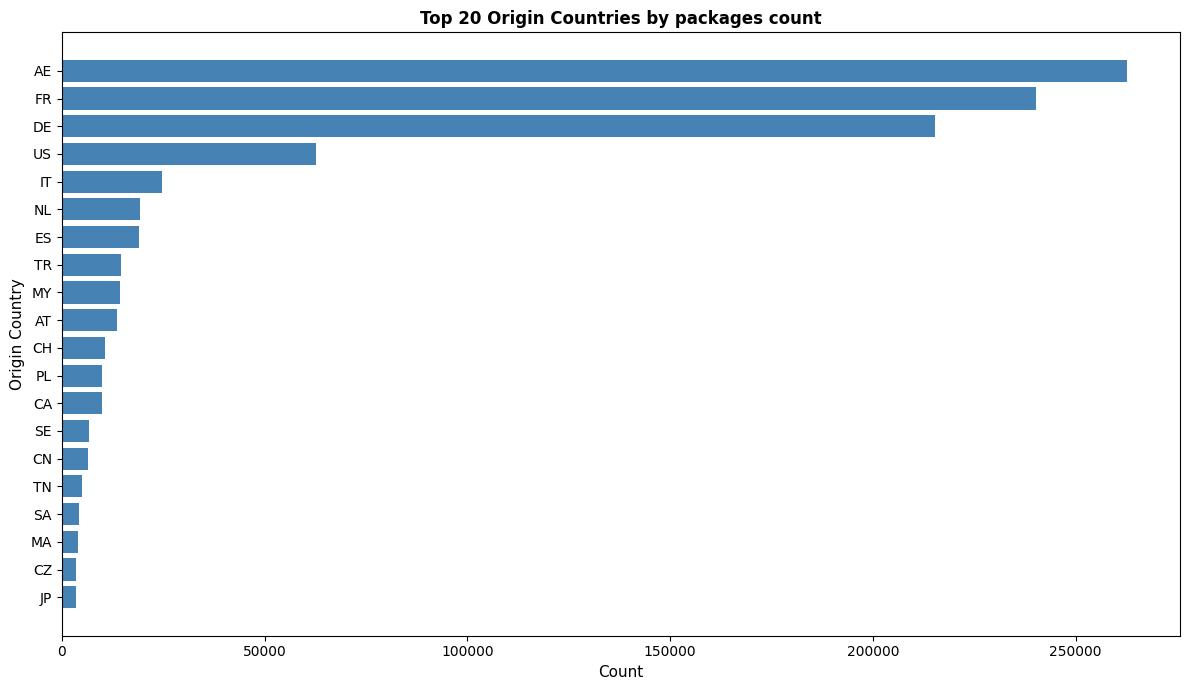

In [193]:
origin_country_counts = parsed_packages_df['origin_country'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(origin_country_counts.index, origin_country_counts.values, color='steelblue')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Origin Country', fontsize=11)
plt.title('Top 20 Origin Countries by packages count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2. for the parsed_receptacles_df

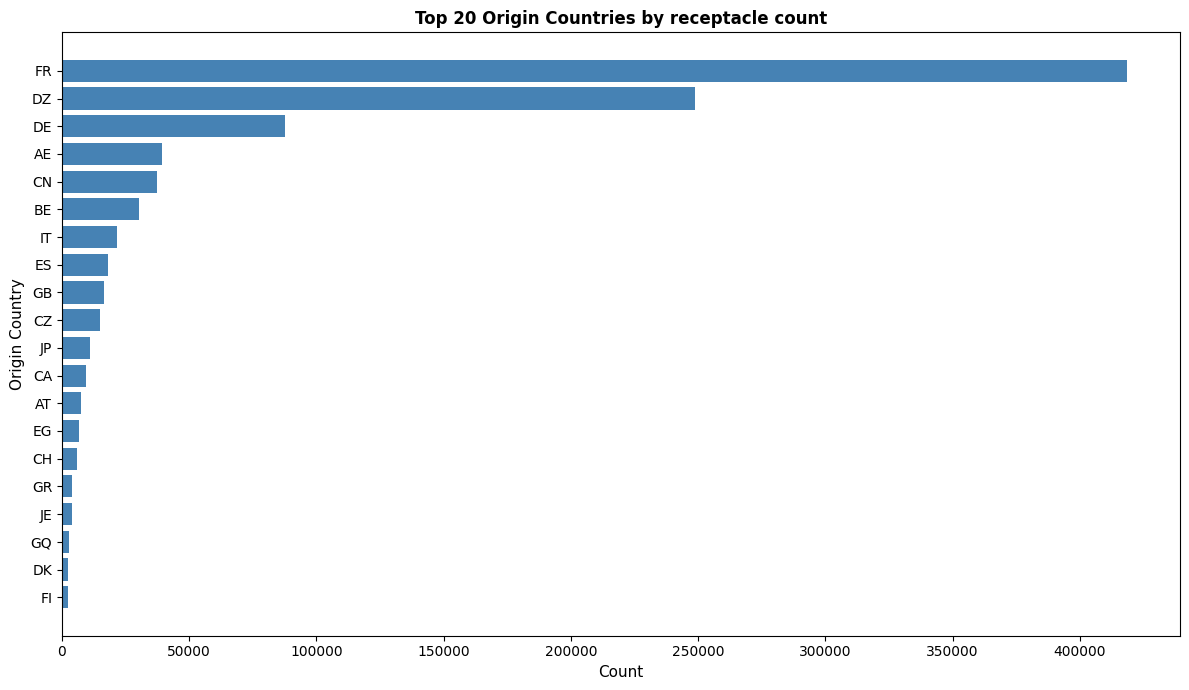

In [194]:
origin_country_counts = parsed_receptacles_df['origin_country'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(origin_country_counts.index, origin_country_counts.values, color='steelblue')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Origin Country', fontsize=11)
plt.title('Top 20 Origin Countries by receptacle count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Visualiation of the service indicator

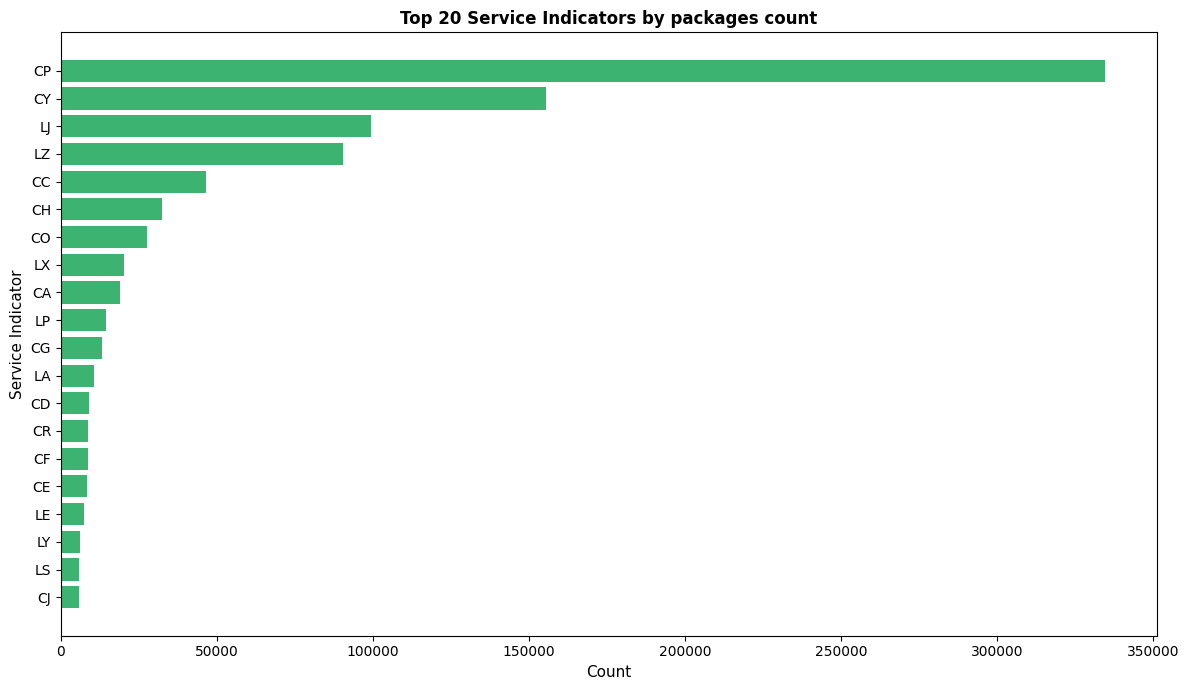

In [195]:
service_indicator_count = parsed_packages_df['service_indicator'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(service_indicator_count.index, service_indicator_count.values, color='mediumseagreen')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Service Indicator', fontsize=11)
plt.title('Top 20 Service Indicators by packages count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Origin–Destination Flow Analysis

This section investigates the flow of receptacles and packages from origin countries to destination. We examine:
- packages count by origin country
- Top origin countries delivering to each destination
- Visual representation 

### 1. parsed_packages_df

In [196]:
# packages count by origin country
origin_country_volume = parsed_packages_df['origin_country'].value_counts()
print("\n--- Packages count by Origin Country ---")
print(origin_country_volume.head(15))

# Create origin_country × destination matrix
flow_matrix = pd.crosstab(parsed_packages_df['origin_country'], 
                           parsed_packages_df['destination_country'])

# Keep only top 10 origin countries and top 10 destination countries for readability
top_origins = parsed_packages_df['origin_country'].value_counts().head(10).index
top_arrivals = parsed_packages_df['destination_country'].value_counts().head(10).index

flow_matrix_top = flow_matrix.loc[top_origins, top_arrivals]

print("\n--- Origin Country × destination Country (Top 10 × Top 10) ---")
print(flow_matrix_top)



--- Packages count by Origin Country ---
origin_country
AE    262591
FR    240310
DE    215237
US     62645
IT     24752
NL     19355
ES     19016
TR     14722
MY     14439
AT     13588
CH     10590
PL      9981
CA      9828
SE      6593
CN      6347
Name: count, dtype: int64

--- Origin Country × destination Country (Top 10 × Top 10) ---
destination_country      DZ
origin_country             
AE                   262591
FR                   240310
DE                   215237
US                    62645
IT                    24752
NL                    19355
ES                    19016
TR                    14722
MY                    14439
AT                    13588


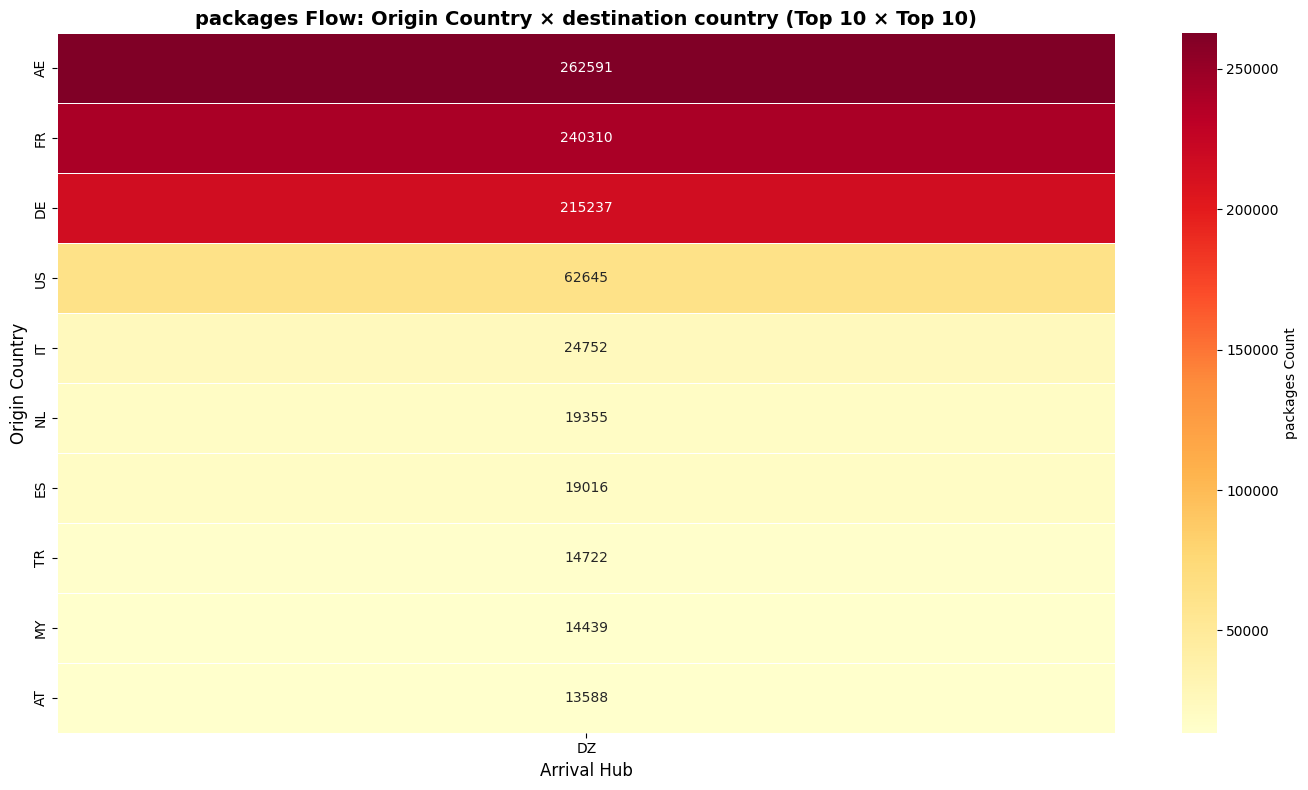

In [197]:
# Visualize origin × destination country flow
plt.figure(figsize=(14, 8))
sns.heatmap(flow_matrix_top, cmap='YlOrRd', annot=True, fmt='d', 
            cbar_kws={'label': 'packages Count'}, linewidths=0.5)
plt.title('packages Flow: Origin Country × destination country (Top 10 × Top 10)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Arrival Hub', fontsize=12)
plt.ylabel('Origin Country', fontsize=12)
plt.tight_layout()
plt.show()


### 2. parsed_receptacles_df

In [198]:
# receptacle count by origin country
origin_country_receptacle_volume = parsed_receptacles_df['origin_country'].value_counts()
print("\n--- Receptacle count by Origin Country ---")
print(origin_country_receptacle_volume.head(15))

destination__receptacle_volume=parsed_receptacles_df['destination_country'].value_counts()
print("\n--- Receptacle count by destination ---")
print(destination__receptacle_volume.head(15))

# Create origin_country × destination matrix
receptacle_flow_matrix = pd.crosstab(parsed_receptacles_df['origin_country'], 
                           parsed_receptacles_df['destination_country'])

# Keep only top 10 origin countries and top 10 destination countries for readability
receptacle_top_origins = parsed_receptacles_df['origin_country'].value_counts().head(10).index
receptacle_top_arrivals = parsed_receptacles_df['destination_country'].value_counts().head(10).index

receptacle_flow_matrix_top = receptacle_flow_matrix.loc[receptacle_top_origins, receptacle_top_arrivals]

print("\n--- Origin Country × destination Country (Top 10 × Top 10) ---")
print(receptacle_flow_matrix_top)



--- Receptacle count by Origin Country ---
origin_country
FR    418448
DZ    248737
DE     87816
AE     39269
CN     37546
BE     30424
IT     21575
ES     17927
GB     16591
CZ     15006
JP     11110
CA      9282
AT      7410
EG      6852
CH      5755
Name: count, dtype: int64

--- Receptacle count by destination ---
destination_country
DZ    748923
FR    126075
CA     22430
DE     12809
US      7944
IT      6079
GB      5895
ES      5713
TR      4730
CH      4707
BE      4126
TN      4069
AE      4056
CN      3339
PL      3095
Name: count, dtype: int64

--- Origin Country × destination Country (Top 10 × Top 10) ---
destination_country      DZ      FR     CA     DE    US    IT    GB    ES  \
origin_country                                                              
FR                   417446       8      2      0    11     0     0     3   
DZ                        5  126066  22428  12807  7933  6079  5895  5706   
DE                    87730       0      0      0     0     0     

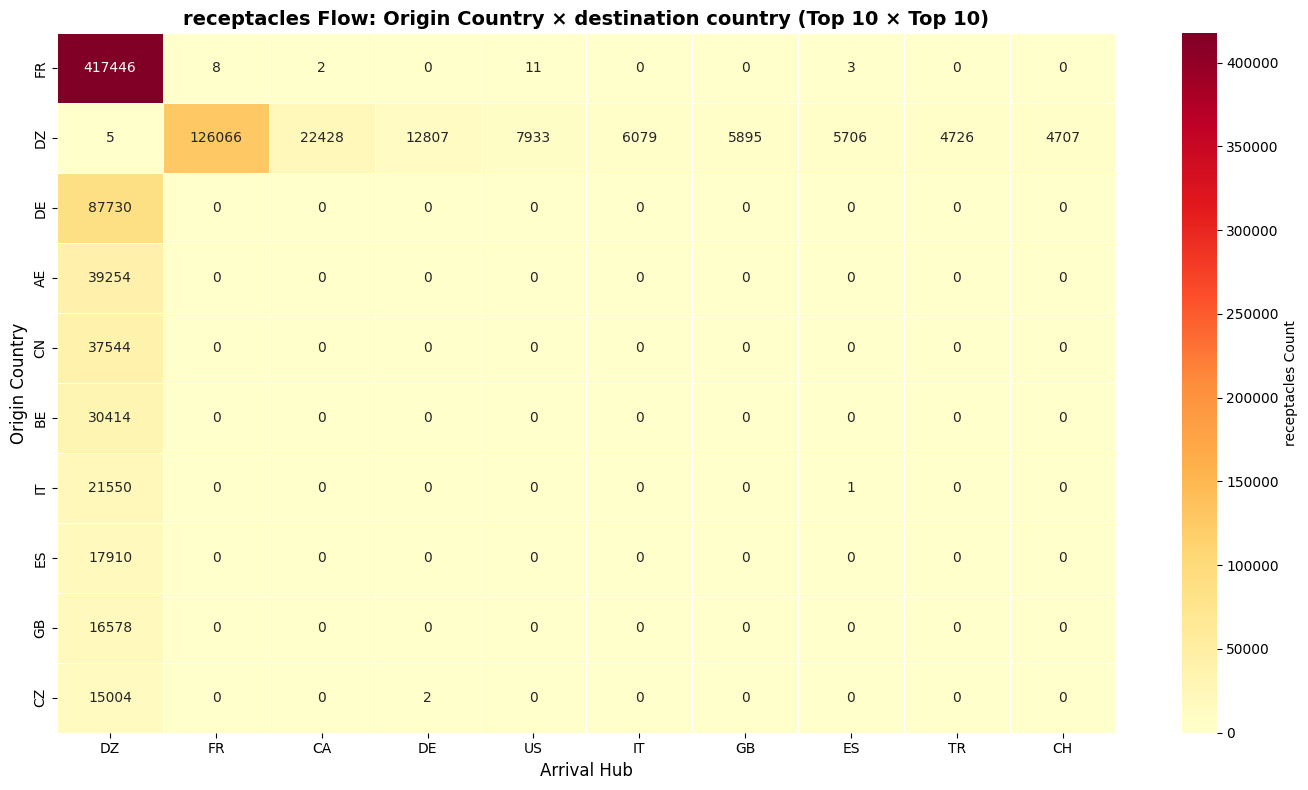

In [199]:
# Visualize origin × destination country flow
plt.figure(figsize=(14, 8))
sns.heatmap(receptacle_flow_matrix_top, cmap='YlOrRd', annot=True, fmt='d', 
            cbar_kws={'label': 'receptacles Count'}, linewidths=0.5)
plt.title('receptacles Flow: Origin Country × destination country (Top 10 × Top 10)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Arrival Hub', fontsize=12)
plt.ylabel('Origin Country', fontsize=12)
plt.tight_layout()
plt.show()


### create pairs (origin, destination) for more detailed analysis

In [200]:
parsed_packages_df['origin_destination'] = parsed_packages_df['origin_country'] + '_' + parsed_packages_df['destination_country']
parsed_receptacles_df['origin_destination'] = parsed_receptacles_df['origin_country'] + '_' + parsed_receptacles_df['destination_country']


listing the obtained values 

In [201]:
print('(origin_destination) pairs obtained for ')
print("\nfor parsed_packages_df :")
print("\nNumber of unique values", parsed_packages_df['origin_destination'].nunique())
print("\nValues : ")
print(parsed_packages_df['origin_destination'].unique())
print("\nfor parsed_receptacles_df :")
print("\nNumber of unique values", parsed_receptacles_df['origin_destination'].nunique())
print("\nValues : ")
print(parsed_receptacles_df['origin_destination'].unique())


(origin_destination) pairs obtained for 

for parsed_packages_df :

Number of unique values 64

Values : 
['FR_DZ' 'CH_DZ' 'MA_DZ' 'US_DZ' 'BE_DZ' 'TG_DZ' 'PK_DZ' 'RU_DZ' 'GR_DZ'
 'JE_DZ' 'CI_DZ' 'PT_DZ' 'TN_DZ' 'AT_DZ' 'AR_DZ' 'KR_DZ' 'DE_DZ' 'JP_DZ'
 'TR_DZ' 'OM_DZ' 'AZ_DZ' 'NL_DZ' 'UA_DZ' 'MD_DZ' 'AE_DZ' 'ES_DZ' 'BG_DZ'
 'GB_DZ' 'IT_DZ' 'SE_DZ' 'CA_DZ' 'NG_DZ' 'HU_DZ' 'NZ_DZ' 'AM_DZ' 'DK_DZ'
 'CZ_DZ' 'SA_DZ' 'FI_DZ' 'CN_DZ' 'LT_DZ' 'HK_DZ' 'TH_DZ' 'ID_DZ' 'IE_DZ'
 'PS_DZ' 'DJ_DZ' 'BJ_DZ' 'GE_DZ' 'BH_DZ' 'MR_DZ' 'IQ_DZ' 'LB_DZ' 'CU_DZ'
 'VN_DZ' 'PL_DZ' 'QA_DZ' 'JO_DZ' 'MY_DZ' 'MV_DZ' 'MU_DZ' 'SG_DZ' 'KG_DZ'
 'EG_DZ']

for parsed_receptacles_df :

Number of unique values 174

Values : 
['AE_DZ' 'AE_MU' 'AE_NE' 'AE_TN' 'AM_DZ' 'AR_DZ' 'AT_DZ' 'AU_NL' 'AU_AE'
 'AZ_DZ' 'AZ_KZ' 'BE_AU' 'BE_CL' 'BE_DZ' 'BE_AR' 'BF_FR' 'BG_DZ' 'BH_DZ'
 'BJ_DZ' 'BY_DZ' 'CA_DZ' 'CG_DZ' 'CH_DZ' 'CH_JP' 'CI_DZ' 'CM_DZ' 'CN_AR'
 'CN_DZ' 'CR_DZ' 'CR_ES' 'CU_DZ' 'CZ_DE' 'CZ_DZ' 'DE_DZ' 'DE_KG' 'DE_LY'
 'DE_ML' 'DE

### visualization of obtained results 

### 1. parsed_packages_df

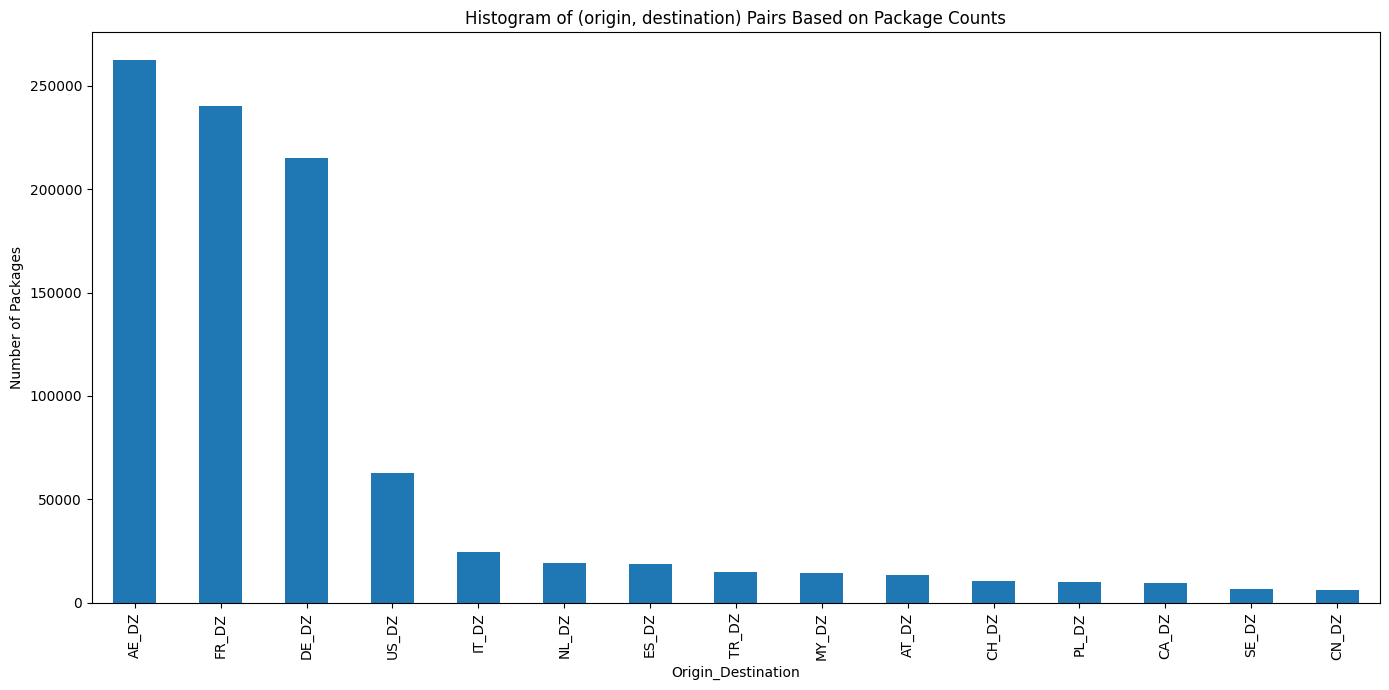

In [202]:
origin_dest_counts = parsed_packages_df['origin_destination'].value_counts()
top_origin_dest_counts= origin_dest_counts.head(15)
plt.figure(figsize=(14, 7))
top_origin_dest_counts.plot(kind='bar')
plt.title('Histogram of (origin, destination) Pairs Based on Package Counts')
plt.xlabel('Origin_Destination')
plt.ylabel('Number of Packages')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



### 2. parsed_receptacles_df

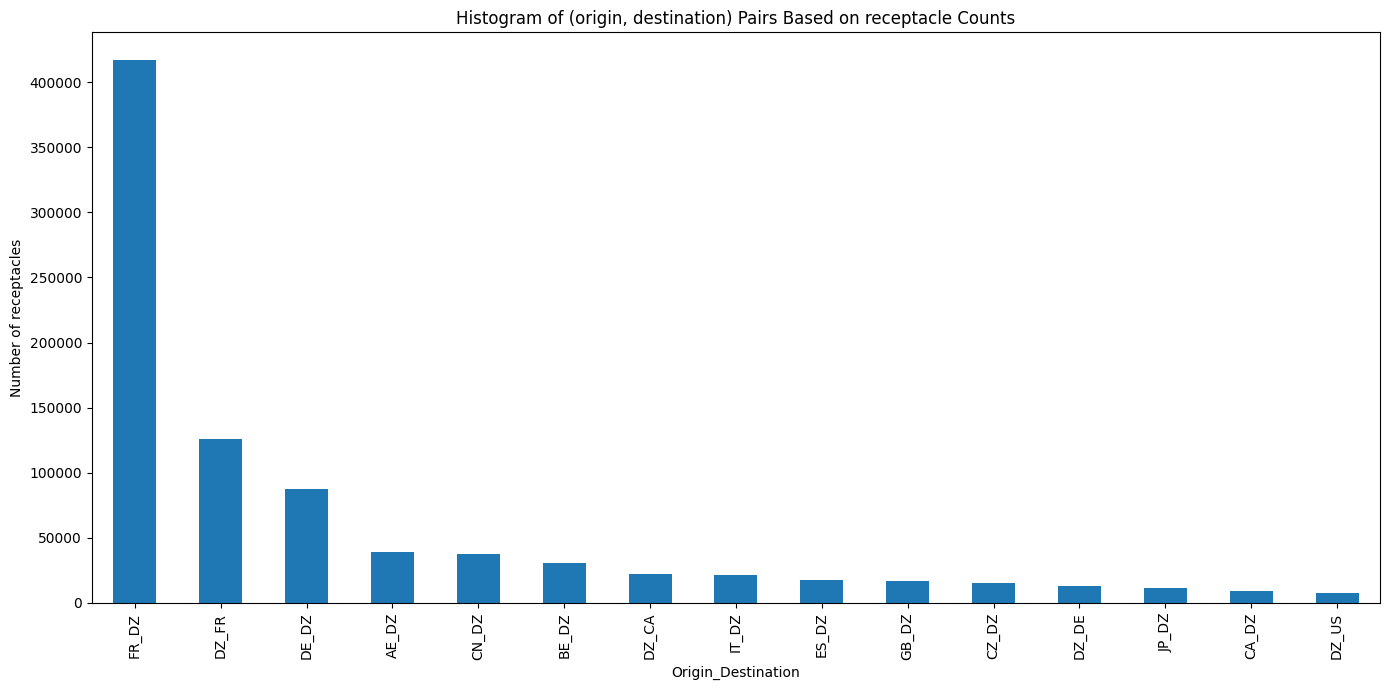

In [203]:
origin_dest_counts = parsed_receptacles_df['origin_destination'].value_counts()
top_origin_dest_counts = origin_dest_counts.head(15)

plt.figure(figsize=(14, 7))
top_origin_dest_counts.plot(kind='bar')
plt.title('Histogram of (origin, destination) Pairs Based on receptacle Counts')
plt.xlabel('Origin_Destination')
plt.ylabel('Number of receptacles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## origin_destination X etablissments analysis 

## 1. current etablissment 

### a. parsed_packages_df

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\1253458664.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


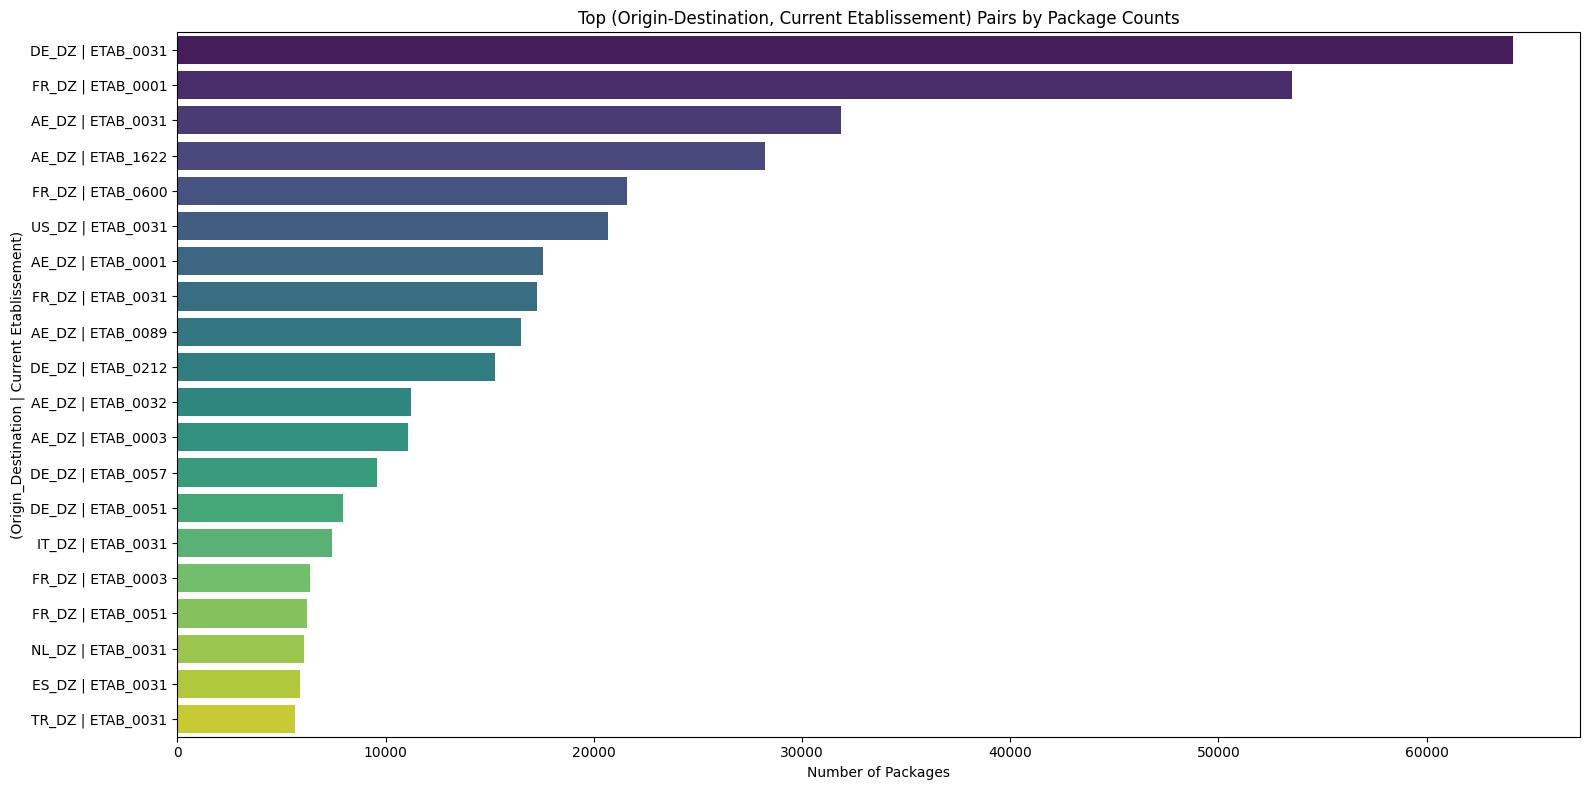

In [204]:
# For parsed_packages_df: visualize the histogram of counts by (origin_destination, etablissement_postal) pairs

# First, select top N most common (origin_destination, etablissement_postal) pairs for clarity
pair_counts_current = parsed_packages_df.groupby(['origin_destination', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_current = pair_counts_current.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_current,
    x='count',
    y=top_pairs_current.apply(lambda x: f"{x['origin_destination']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Current Etablissement) Pairs by Package Counts')
plt.xlabel('Number of Packages')
plt.ylabel('(Origin_Destination | Current Etablissement)')
plt.tight_layout()
plt.show()


### b. parsed_receptacles_df

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\878701745.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


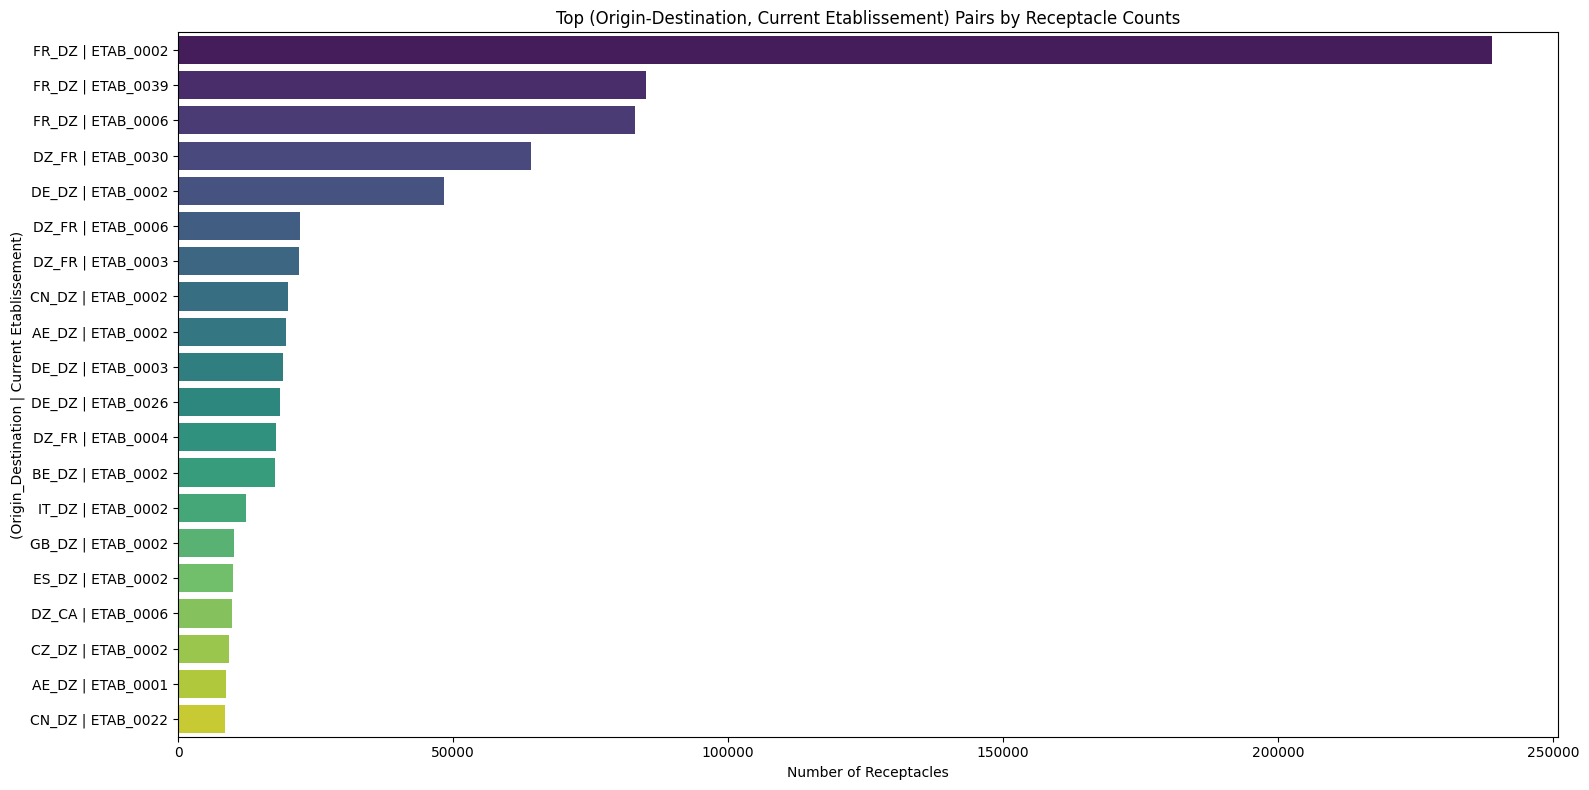

In [205]:
# For parsed_receptacles_dffffff: visualize the histogram of counts by (origin_destination, etablissement_postal) pairs

# First, select top N most common (origin_destination, etablissement_postal) pairs for clarity
pair_counts_current_receptacle = parsed_receptacles_df.groupby(['origin_destination', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_current_receptacle = pair_counts_current_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_current_receptacle,
    x='count',
    y=top_pairs_current_receptacle.apply(lambda x: f"{x['origin_destination']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Destination | Current Etablissement)')
plt.tight_layout()
plt.show()


we can see that the ETAB0002 is dominating and we remark that when the destination is DZ
we'll try to confirm that by taking into consideration the destination only


C:\Users\djame\AppData\Local\Temp\ipykernel_24572\3606863427.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


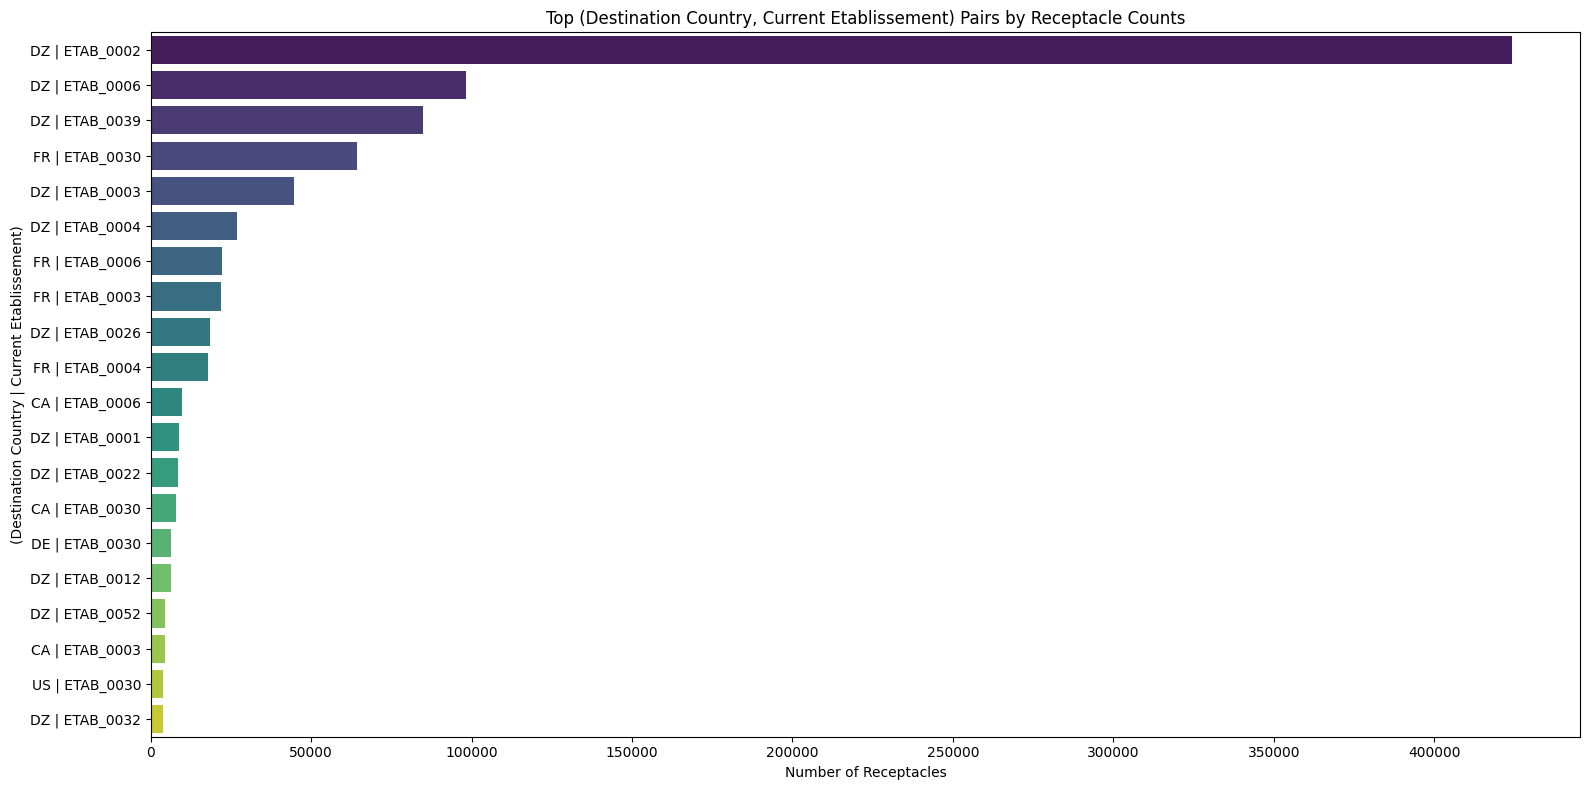

In [206]:
# For parsed_receptacles_dffff: visualize the histogram of counts by (destination_country, etablissement_postal) pairs

# First, select top N most common (destination_country, etablissement_postal) pairs for clarity
pair_counts_dest_receptacle = parsed_receptacles_df.groupby(['destination_country', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_dest_receptacle = pair_counts_dest_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_dest_receptacle,
    x='count',
    y=top_pairs_dest_receptacle.apply(lambda x: f"{x['destination_country']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Destination Country, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Destination Country | Current Etablissement)')
plt.tight_layout()
plt.show()


### This is to test the origin 

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\3381271627.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


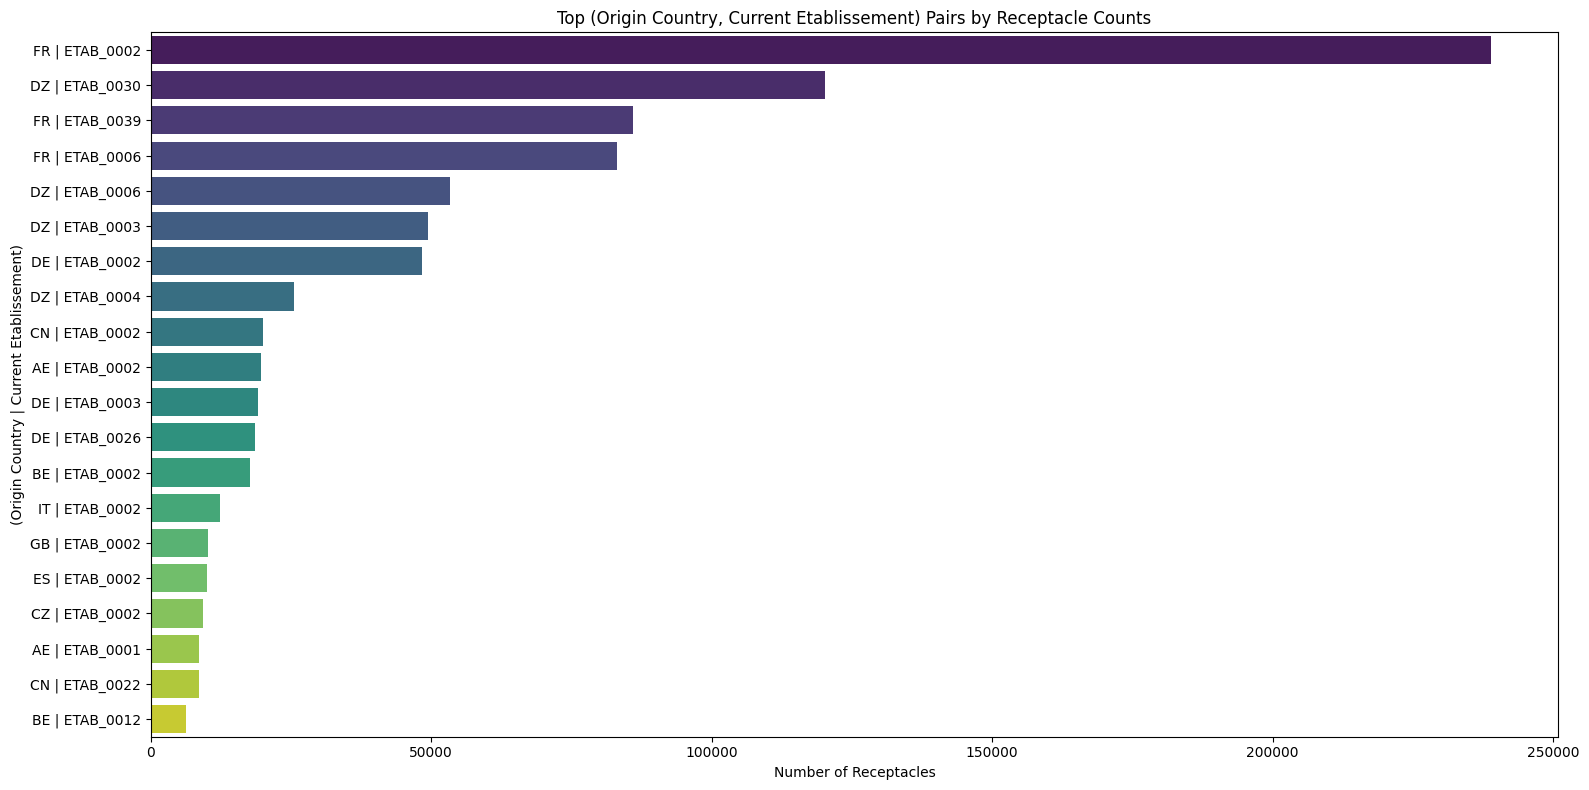

In [207]:
# For parsed_receptacles_dffffff: visualize the histogram of counts by (origin_country, etablissement_postal) pairs

# First, select top N most common (origin_country, etablissement_postal) pairs for clarity
pair_counts_origin_receptacle = parsed_receptacles_df.groupby(['origin_country', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_origin_receptacle = pair_counts_origin_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_origin_receptacle,
    x='count',
    y=top_pairs_origin_receptacle.apply(lambda x: f"{x['origin_country']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin Country, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin Country | Current Etablissement)')
plt.tight_layout()
plt.show()


most of the values with ETAB0002 values are european countries in addition to AE and China(CN)

## 2. Next etablissement

### a. parsed_packages_df

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\2809534773.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


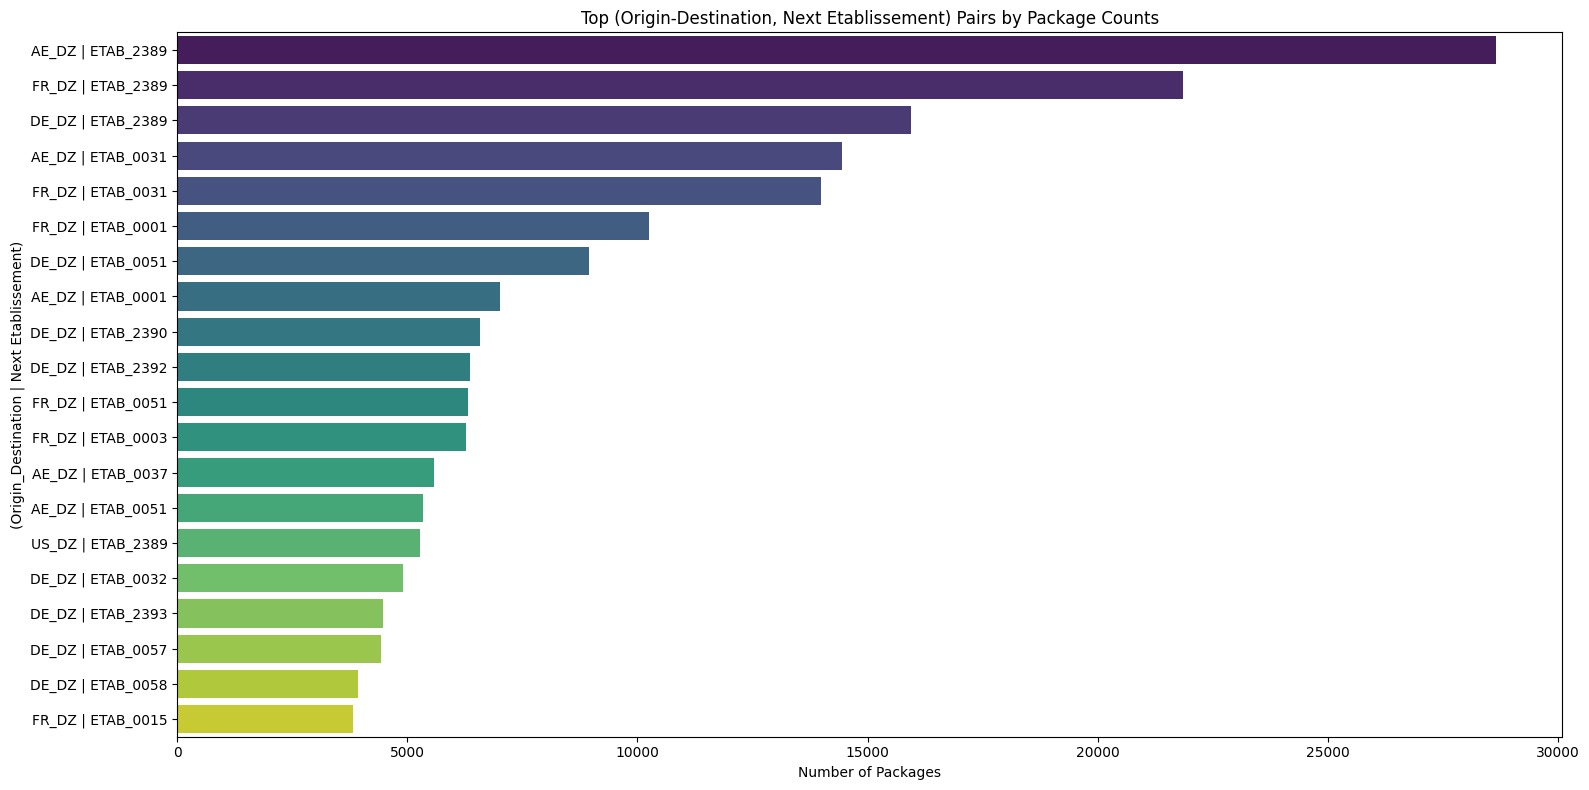

In [208]:
# For parsed_packages_df: visualize the histogram of counts by (origin_destination, next_etablissement_postal)

# First, select top N most common (origin_destination, next_etablissement_postal) pairs for clarity
pair_counts = parsed_packages_df.groupby(['origin_destination', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs = pair_counts.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs,
    x='count',
    y=top_pairs.apply(lambda x: f"{x['origin_destination']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Next Etablissement) Pairs by Package Counts')
plt.xlabel('Number of Packages')
plt.ylabel('(Origin_Destination | Next Etablissement)')
plt.tight_layout()
plt.show()


### b. parsed_receptacles_df

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\3719778436.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


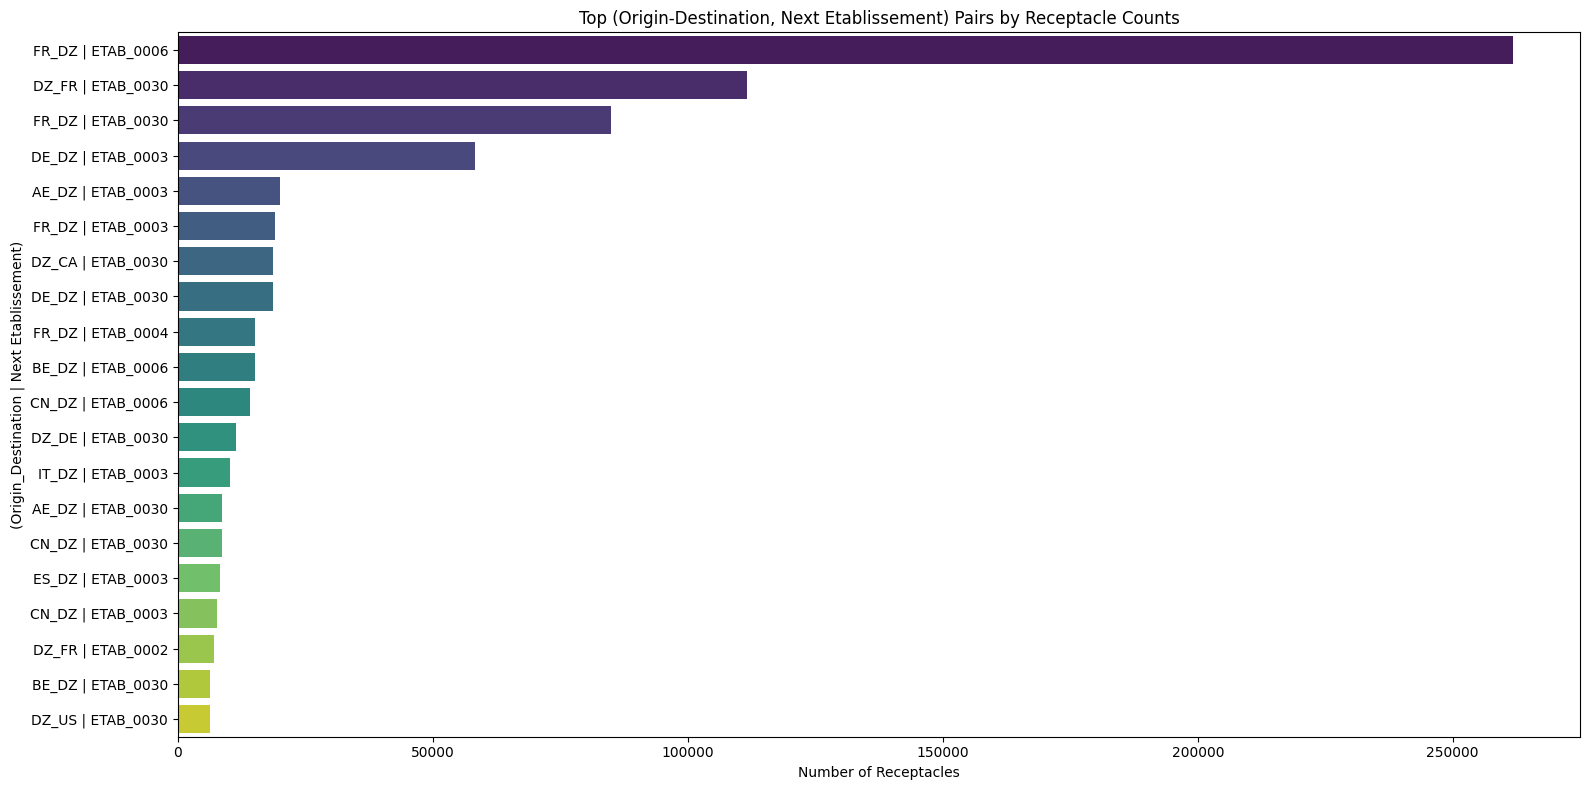

In [209]:
# For parsed_receptacles_dffff: visualize the histogram of counts by (origin_destination, next_etablissement_postal)

# First, select top N most common (origin_destination, next_etablissement_postal) pairs for clarity
pair_counts_recept = parsed_receptacles_df.groupby(['origin_destination', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_recept = pair_counts_recept.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_recept,
    x='count',
    y=top_pairs_recept.apply(lambda x: f"{x['origin_destination']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Destination | Next Etablissement)')
plt.tight_layout()
plt.show()



Do for origin and for destination separately

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\2854299532.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


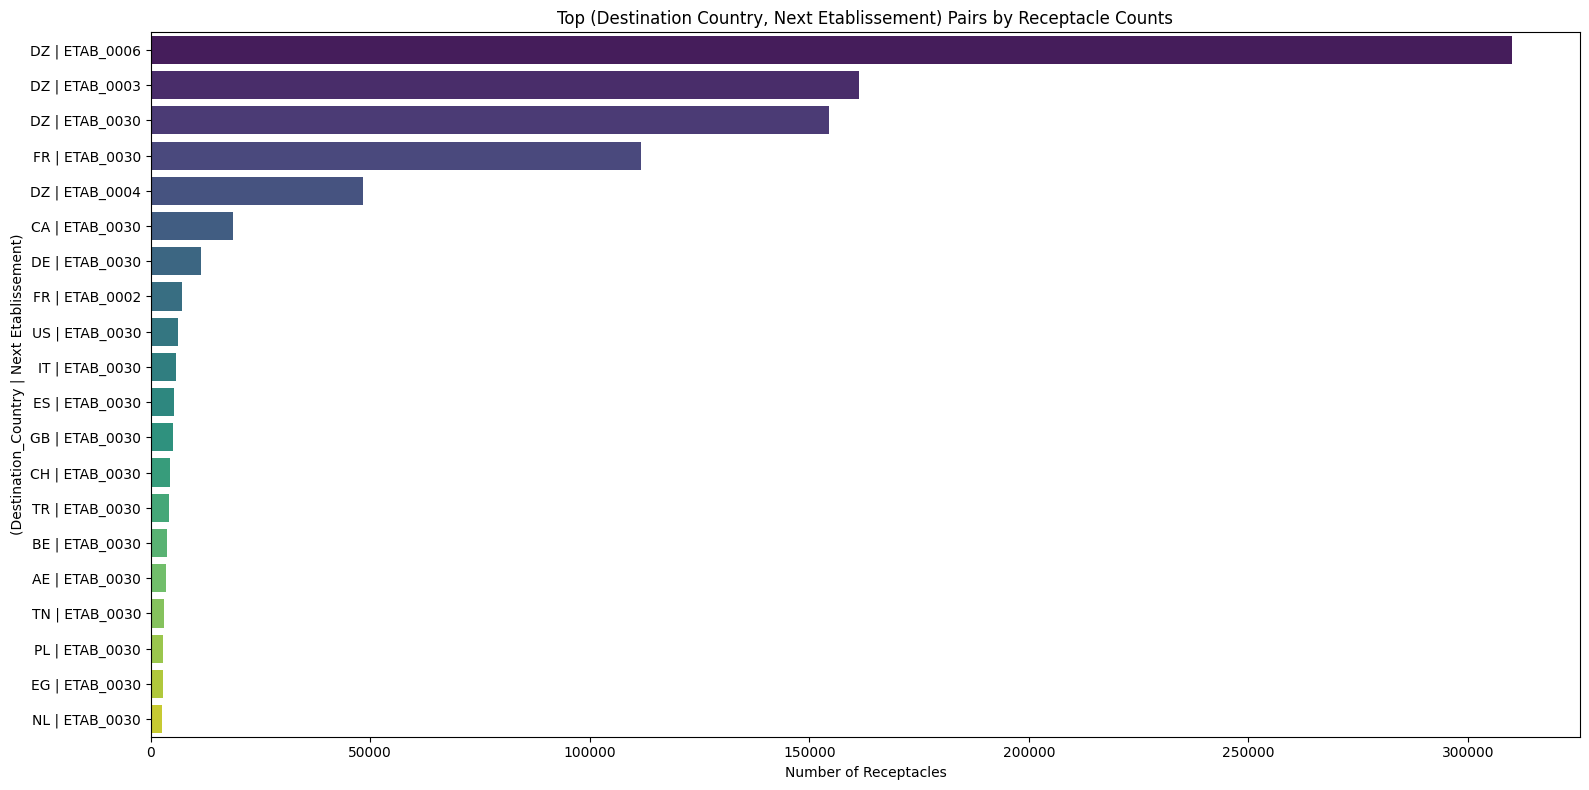

In [210]:

# For parsed_receptacles_df: visualize the histogram of counts by destination_country and next_etablissement_postal

# First, select top N most common (destination_country, next_etablissement_postal) pairs for clarity
pair_counts_dest = parsed_receptacles_df.groupby(['destination_country', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_dest = pair_counts_dest.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_dest,
    x='count',
    y=top_pairs_dest.apply(lambda x: f"{x['destination_country']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Destination Country, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Destination_Country | Next Etablissement)')
plt.tight_layout()
plt.show()


C:\Users\djame\AppData\Local\Temp\ipykernel_24572\2460867481.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


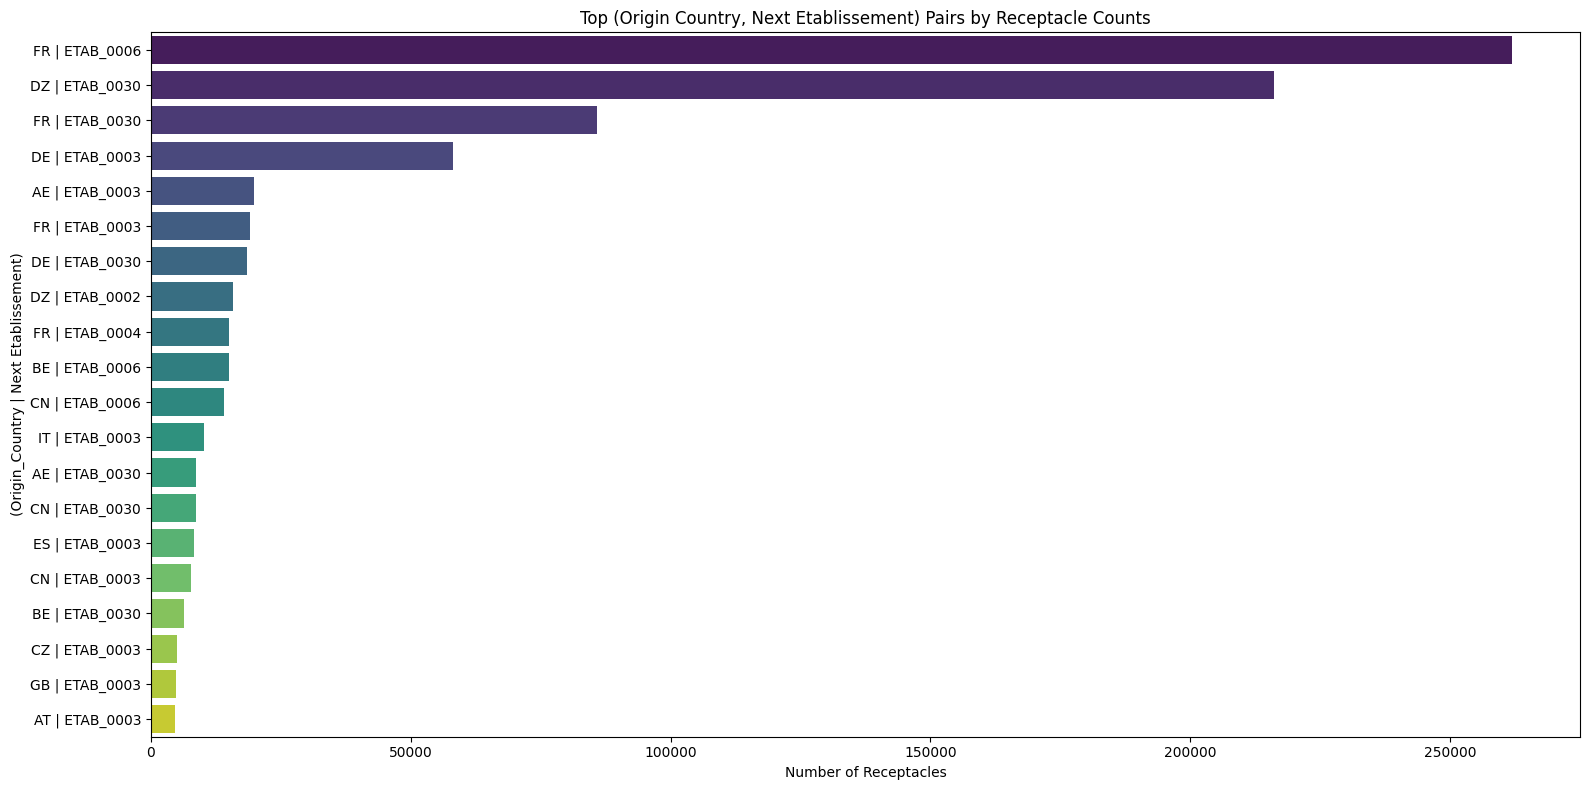

In [211]:
# For parsed_receptacles_df: visualize the histogram of counts by origin_country and next_etablissement_postal

# First, select top N most common (origin_country, next_etablissement_postal) pairs for clarity
pair_counts_origin = parsed_receptacles_df.groupby(['origin_country', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_origin = pair_counts_origin.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_origin,
    x='count',
    y=top_pairs_origin.apply(lambda x: f"{x['origin_country']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin Country, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Country | Next Etablissement)')
plt.tight_layout()
plt.show()


from the analysis we can see that there are some etablissments that get congested forming a sort of loop (ETAB0030, ETAB0002, ETAB0006)

### Time analysis regarding origin

### 1. parsed_packages_df

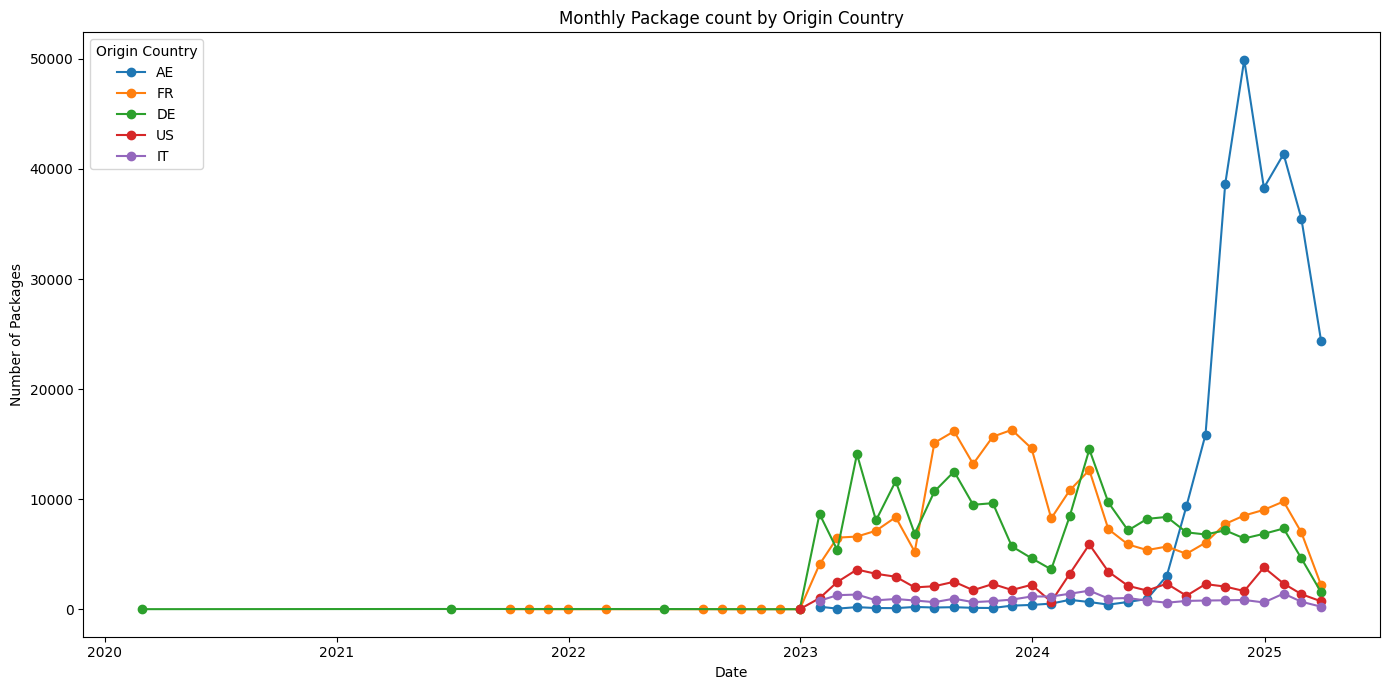

In [212]:
# Group the parsed_packages_df by date and origin_country to count packages per month per origin country
parsed_packages_df['date'] = pd.to_datetime(parsed_packages_df['date'])

# Group by origin_country and resample by month
ts_by_origin = parsed_packages_df.groupby(['origin_country', pd.Grouper(key='date', freq='ME')])['MAILITM_FID'].count().reset_index()

# Choose top 5 origin countries by total count for plotting
top_origin = parsed_packages_df['origin_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for origin in top_origin:
    ts = ts_by_origin[ts_by_origin['origin_country'] == origin]
    plt.plot(ts['date'], ts['MAILITM_FID'], marker='o', label=origin)

plt.title('Monthly Package count by Origin Country')
plt.xlabel('Date')
plt.ylabel('Number of Packages')
plt.legend(title='Origin Country')
plt.tight_layout()
plt.show()


### 2. parsed_receptacles_dfffff

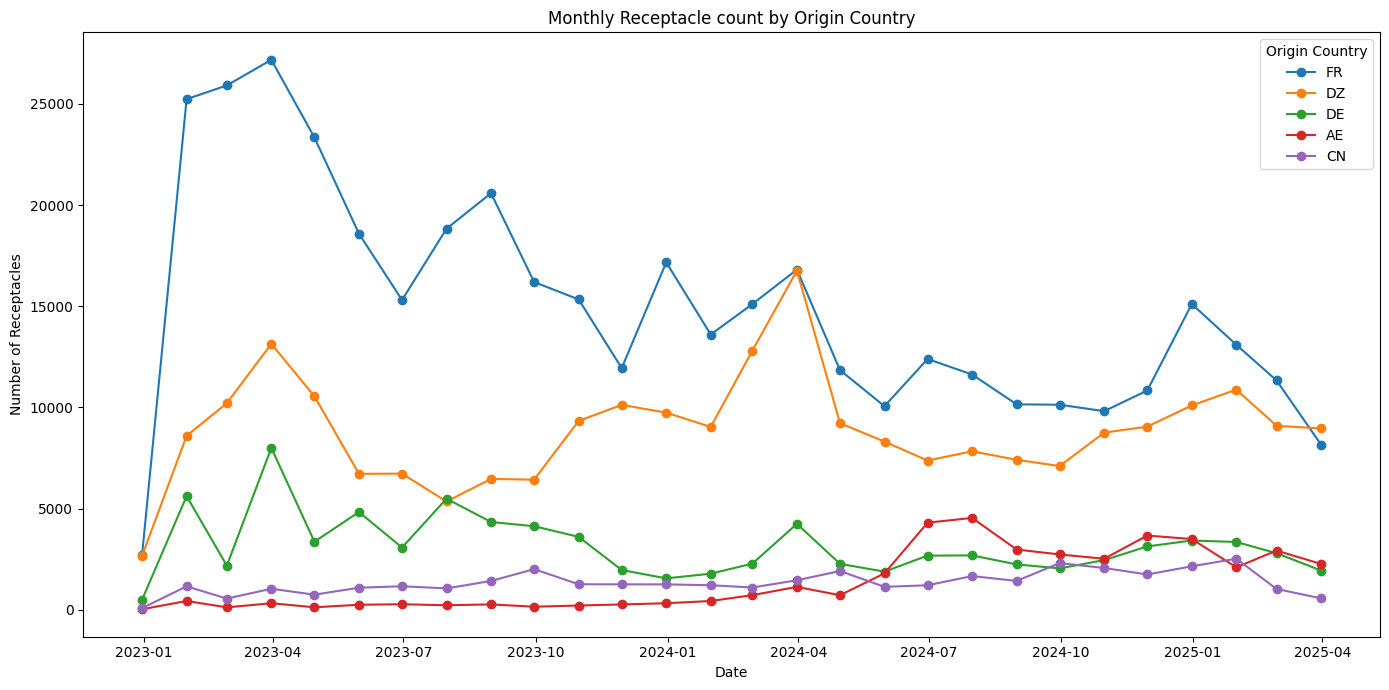

In [213]:
# Group the parsed_receptacles_df by date and origin_country to count receptacles per month per origin country
parsed_receptacles_df['date'] = pd.to_datetime(parsed_receptacles_df['date'])

# Group by origin_country and resample by month
ts_by_origin_recept = parsed_receptacles_df.groupby(['origin_country', pd.Grouper(key='date', freq='ME')])['RECPTCL_FID'].count().reset_index()

# Choose top 5 origin countries by total count for plotting
top_origin_recept = parsed_receptacles_df['origin_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for origin in top_origin_recept:
    ts = ts_by_origin_recept[ts_by_origin_recept['origin_country'] == origin]
    plt.plot(ts['date'], ts['RECPTCL_FID'], marker='o', label=origin)

plt.title('Monthly Receptacle count by Origin Country')
plt.xlabel('Date')
plt.ylabel('Number of Receptacles')
plt.legend(title='Origin Country')
plt.tight_layout()
plt.show()


### Time analysis by destination

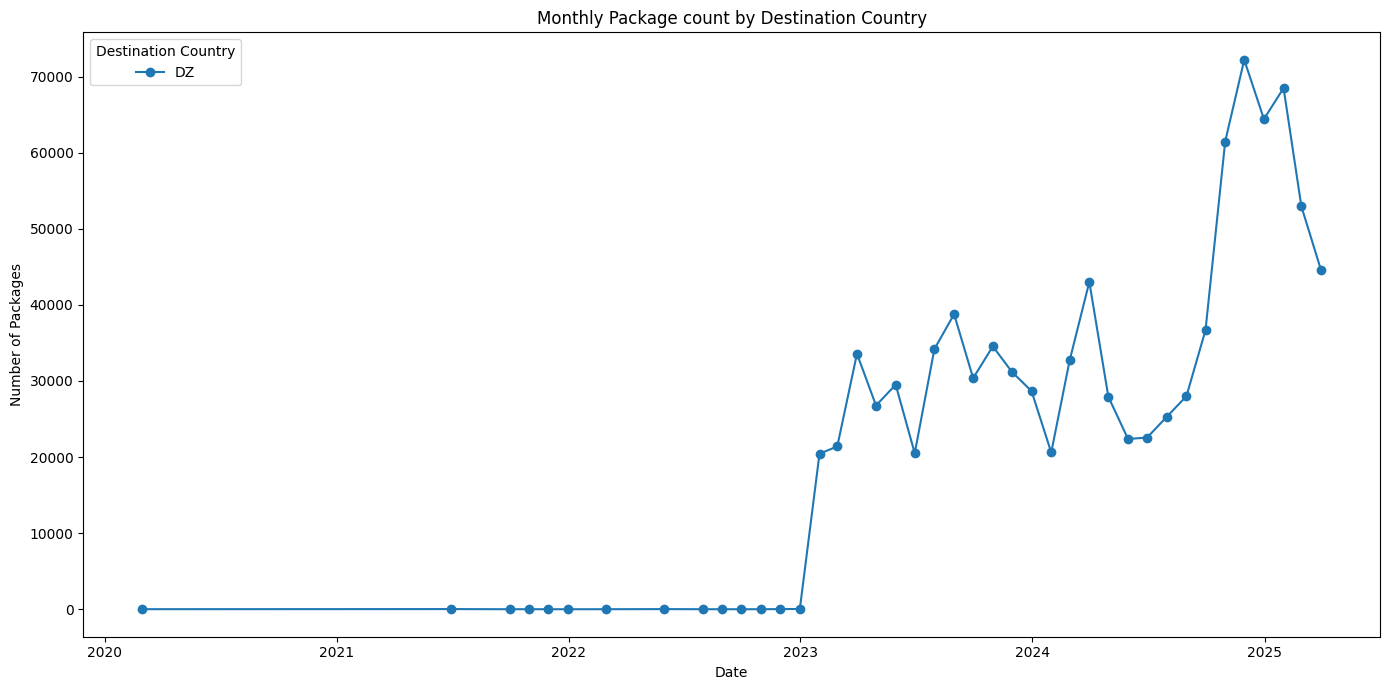

In [214]:
# Group the parsed_packages_df by date and destination_country to count packages per month per destination country
parsed_packages_df['date'] = pd.to_datetime(parsed_packages_df['date'])

# Group by destination_country and resample by month
ts_by_dest = parsed_packages_df.groupby(['destination_country', pd.Grouper(key='date', freq='ME')])['MAILITM_FID'].count().reset_index()

# Choose top 5 destination countries by total count for plotting
top_dest = parsed_packages_df['destination_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for dest in top_dest:
    ts = ts_by_dest[ts_by_dest['destination_country'] == dest]
    plt.plot(ts['date'], ts['MAILITM_FID'], marker='o', label=dest)

plt.title('Monthly Package count by Destination Country')
plt.xlabel('Date')
plt.ylabel('Number of Packages')
plt.legend(title='Destination Country')
plt.tight_layout()
plt.show()


### 2. parsed_receptacles_dffff

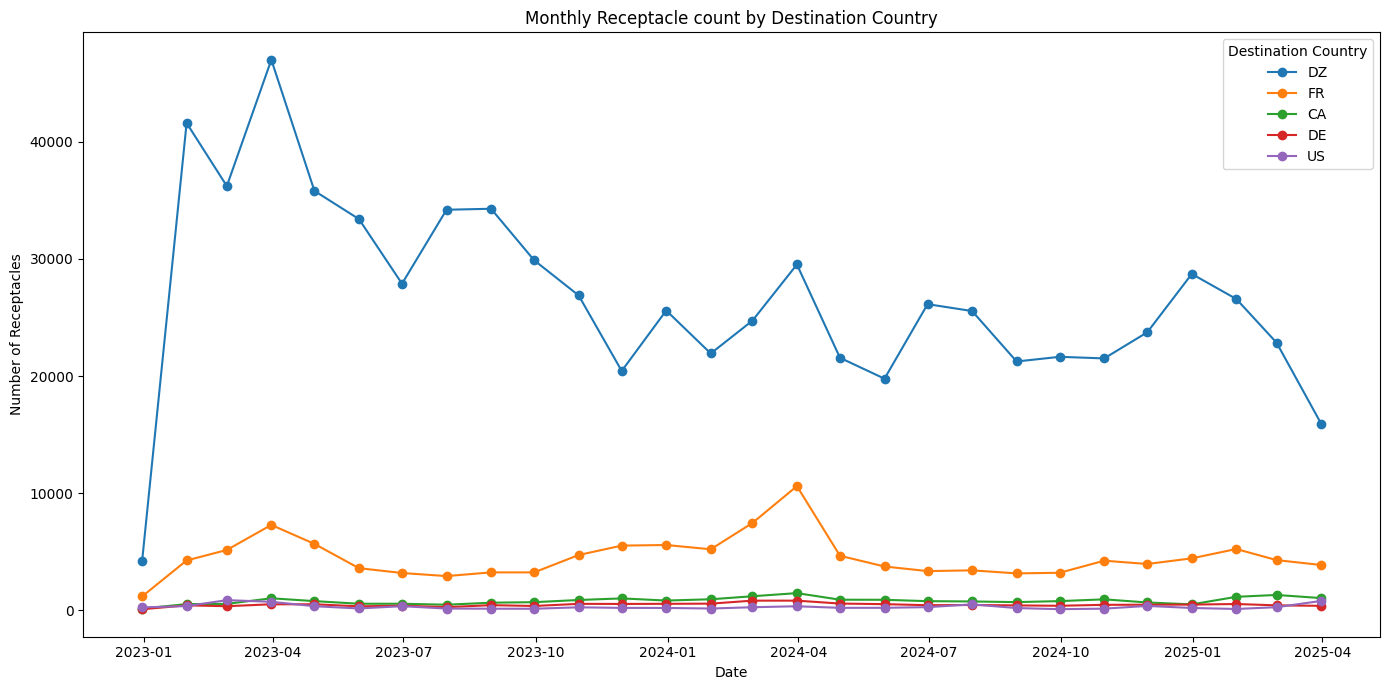

In [215]:
# Group the parsed_receptacles_df by date and destination_country to count receptacles per month per destination country
parsed_receptacles_df['date'] = pd.to_datetime(parsed_receptacles_df['date'])

# Group by destination_country and resample by month 
ts_by_dest_recept = parsed_receptacles_df.groupby(['destination_country', pd.Grouper(key='date', freq='ME')])['RECPTCL_FID'].count().reset_index()

# Choose top 5 destination countries by total count for plotting
top_dest_recept = parsed_receptacles_df['destination_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for dest in top_dest_recept:
    ts = ts_by_dest_recept[ts_by_dest_recept['destination_country'] == dest]
    plt.plot(ts['date'], ts['RECPTCL_FID'], marker='o', label=dest)

plt.title('Monthly Receptacle count by Destination Country')
plt.xlabel('Date')
plt.ylabel('Number of Receptacles')
plt.legend(title='Destination Country')
plt.tight_layout()
plt.show()


## Creating additional features 
 1. 'flow_type' column with values: 'inbound' (to DZ), 'outbound' (from DZ), 'local' (DZ to DZ), otherwise 'other'

In [216]:
import numpy as np

def get_flow_type(df):
    # Define the conditions
    conditions = [
        (df['destination_country'] == 'DZ') & (df['origin_country'] == 'DZ'), # local
        (df['destination_country'] == 'DZ'),                                # inbound
        (df['origin_country'] == 'DZ')                                     # outbound
    ]
    
    # Define the results for each condition
    choices = ['local', 'inbound', 'outbound']
    
    # Apply logic with 'other' as the default
    return np.select(conditions, choices, default='other')

# Apply to both DataFrames instantly
parsed_packages_df['flow_type'] = get_flow_type(parsed_packages_df)
parsed_receptacles_df['flow_type'] = get_flow_type(parsed_receptacles_df)

# Print counts
print("Flow type counts in parsed_packages_df:\n", parsed_packages_df['flow_type'].value_counts())
print("\nFlow type counts in parsed_receptacles_df:\n", parsed_receptacles_df['flow_type'].value_counts())

Flow type counts in parsed_packages_df:
 flow_type
inbound    973228
Name: count, dtype: int64

Flow type counts in parsed_receptacles_df:
 flow_type
inbound     748918
outbound    248732
other         1234
local            5
Name: count, dtype: int64


we can see that there are some values of flow type with the type "other"

In [217]:
# Display the first 10 rows of origin_country and destination_country for flow_type 'other' in parsed_receptacles_df
print(parsed_receptacles_df.loc[parsed_receptacles_df['flow_type'] == 'other', ['origin_country', 'destination_country']].head(10))



      origin_country destination_country
39254             AE                  MU
39255             AE                  MU
39256             AE                  NE
39257             AE                  NE
39258             AE                  NE
39259             AE                  NE
39260             AE                  NE
39261             AE                  NE
39262             AE                  NE
39263             AE                  NE


## Analysis of the relation between the flow_type and the event_type

## 1. parsed_packages_df

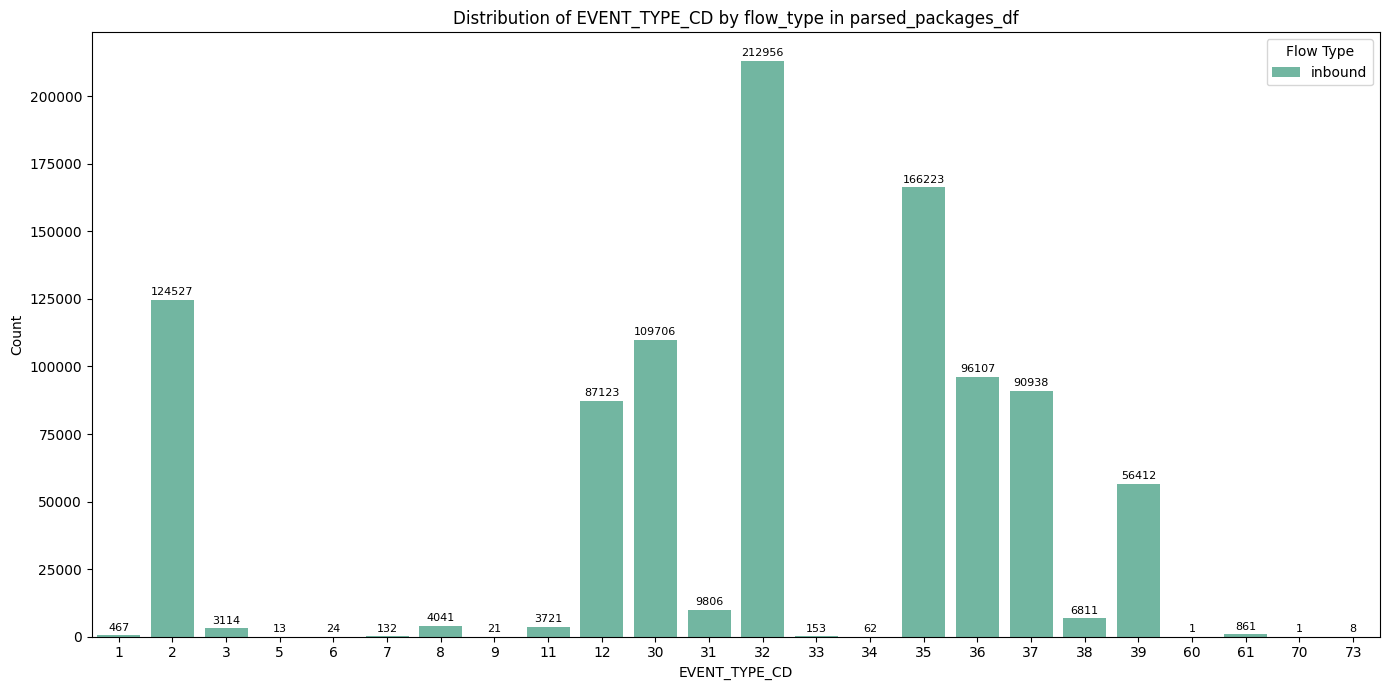

In [218]:

# Analyse relation between flow_type and EVENT_TYPE_CD in parsed_packages_df

plt.figure(figsize=(14,7))
ax = sns.countplot(data=parsed_packages_df, x="EVENT_TYPE_CD", hue="flow_type", palette='Set2')
plt.title("Distribution of EVENT_TYPE_CD by flow_type in parsed_packages_df")
plt.xlabel("EVENT_TYPE_CD")
plt.ylabel("Count")
plt.legend(title="Flow Type")
plt.tight_layout()
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=8, padding=2)
plt.show()



## 2. parsed_receptacles_df

In [219]:
# For each flow_type, list the unique EVENT_TYPE_CD values and the most frequent EVENT_TYPE_CD value
for flow in parsed_receptacles_df['flow_type'].unique():
    event_types = parsed_receptacles_df.loc[parsed_receptacles_df['flow_type'] == flow, 'EVENT_TYPE_CD'].unique()
    most_common_event_type = parsed_receptacles_df.loc[parsed_receptacles_df['flow_type'] == flow, 'EVENT_TYPE_CD'].mode()
    print(f"Flow type: {flow}")
    print(f"EVENT_TYPE_CD values: {sorted(event_types)}")
    if not most_common_event_type.empty:
        print(f"Most frequent EVENT_TYPE_CD: {most_common_event_type.iloc[0]}")
    else:
        print("No EVENT_TYPE_CD available")
    print()   


Flow type: inbound
EVENT_TYPE_CD values: [np.int64(103), np.int64(106), np.int64(107), np.int64(130), np.int64(131), np.int64(132), np.int64(133), np.int64(178)]
Most frequent EVENT_TYPE_CD: 130

Flow type: other
EVENT_TYPE_CD values: [np.int64(104), np.int64(105), np.int64(106), np.int64(130), np.int64(131), np.int64(132), np.int64(135), np.int64(178)]
Most frequent EVENT_TYPE_CD: 135

Flow type: outbound
EVENT_TYPE_CD values: [np.int64(100), np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(130), np.int64(132), np.int64(134), np.int64(135), np.int64(160), np.int64(161), np.int64(178)]
Most frequent EVENT_TYPE_CD: 161

Flow type: local
EVENT_TYPE_CD values: [np.int64(130), np.int64(178)]
Most frequent EVENT_TYPE_CD: 130



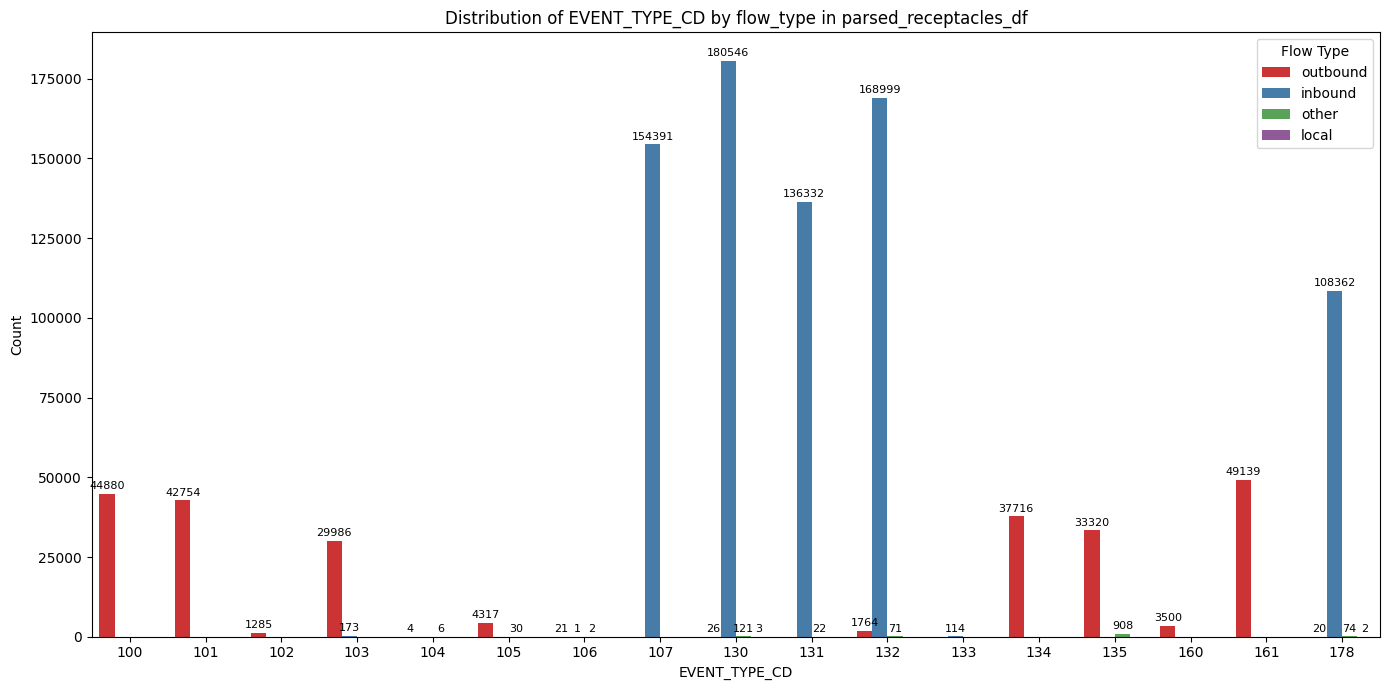

In [220]:
plt.figure(figsize=(14,7))
ax = sns.countplot(data=parsed_receptacles_df, x="EVENT_TYPE_CD", hue="flow_type", palette='Set1')
plt.title("Distribution of EVENT_TYPE_CD by flow_type in parsed_receptacles_df")
plt.xlabel("EVENT_TYPE_CD")
plt.ylabel("Count")
plt.legend(title="Flow Type")
plt.tight_layout()

for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=8, padding=2)

plt.show()


we can see that there are major event types related to the inbound flow type( coming to DZ)

# Track multiple receptacles just to see the flow of events


--- Events for RECPTCL_FID: AEDXBADZAAEDACN45001001100219 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,107,ETAB_0001,ETAB_0030
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,130,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,132,ETAB_0002,ETAB_0003
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,132,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45002001100075 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,107,ETAB_0001,ETAB_0030
1,AEDXBADZAAEDACN45002001100075,2024-07-28 15:48:40.283,130,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45002001100075,2024-07-28 15:59:01.350,132,ETAB_0002,ETAB_0003
3,AEDXBADZAAEDACN45002001100075,2024-07-30 09:42:01.093,103,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45003001100123 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45003001100123,2024-07-29 15:09:53.093,130,ETAB_0002,ETAB_0001
1,AEDXBADZAAEDACN45003001100123,2024-07-29 15:12:43.660,132,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45003001100123,2024-07-30 08:45:00.000,107,ETAB_0001,ETAB_0030
3,AEDXBADZAAEDACN45003001100123,2024-07-30 09:41:09.840,103,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45004001100073 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45004001100073,2024-07-29 15:09:40.170,130,ETAB_0002,ETAB_0001
1,AEDXBADZAAEDACN45004001100073,2024-07-29 15:12:31.177,132,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45004001100073,2024-07-30 08:45:00.000,107,ETAB_0001,ETAB_0030
3,AEDXBADZAAEDACN45004001100073,2024-07-30 09:42:18.070,103,ETAB_0003,ETAB_0033



--- Events for RECPTCL_FID: AEDXBADZAAEDACN45005001100107 ---


,RECPTCL_FID,date,EVENT_TYPE_CD,etablissement_postal,next_etablissement_postal
0,AEDXBADZAAEDACN45005001100107,2024-07-31 08:45:00.000,107,ETAB_0001,ETAB_0030
1,AEDXBADZAAEDACN45005001100107,2024-08-01 13:24:48.073,130,ETAB_0002,ETAB_0003
2,AEDXBADZAAEDACN45005001100107,2024-08-01 13:37:18.410,132,ETAB_0002,ETAB_0003
3,AEDXBADZAAEDACN45005001100107,2024-08-13 13:55:44.133,132,ETAB_0003,ETAB_0033


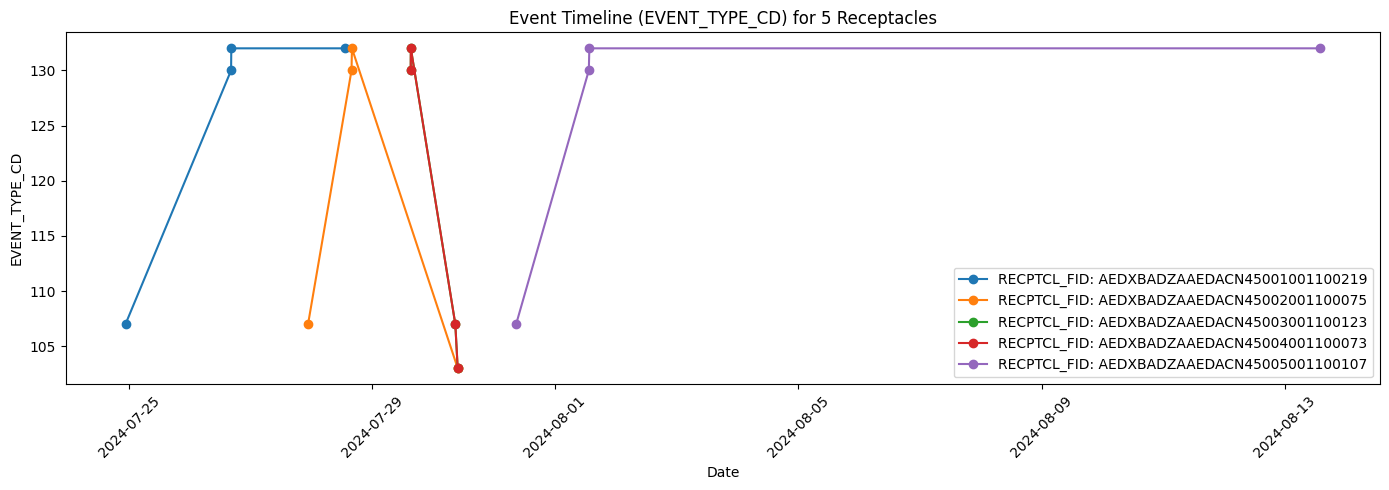

In [221]:
# Track multiple receptacles: visualize all events for 5 different RECPTCL_FID in parsed_receptacles_df
# Pick 5 unique RECPTCL_FID values to demonstrate
num_examples = 5
example_receptacle_ids = parsed_receptacles_df['RECPTCL_FID'].drop_duplicates().iloc[:num_examples]
for rid in example_receptacle_ids:
    print("\n--- Events for RECPTCL_FID:", rid, "---")
    display(parsed_receptacles_df[parsed_receptacles_df['RECPTCL_FID'] == rid][['RECPTCL_FID', 'date', 'EVENT_TYPE_CD', 'etablissement_postal', 'next_etablissement_postal']].sort_values('date').reset_index(drop=True))


plt.figure(figsize=(14, 5))

for i, receptacle_id in enumerate(example_receptacle_ids):
    ex_df = parsed_receptacles_df[parsed_receptacles_df['RECPTCL_FID'] == receptacle_id].sort_values('date')
    plt.plot(
        ex_df['date'],
        ex_df['EVENT_TYPE_CD'],
        marker='o',
        label=f"RECPTCL_FID: {receptacle_id}"
    )

plt.xticks(rotation=45)
plt.title(f"Event Timeline (EVENT_TYPE_CD) for {num_examples} Receptacles")
plt.xlabel("Date")
plt.ylabel("EVENT_TYPE_CD")
plt.tight_layout()
plt.legend()
plt.show()


# **ATTENTION**

* ... **Add feature engineering starting from here, as the next part is the splitting part, and it needs to be done to the whole datasets** ...

In [222]:
# HERE

In [223]:
# HERE

# Splitting

* Splitting `packages` and dataset into training and testing sets using `train_test_split`

In [224]:
from sklearn.model_selection import train_test_split

# Step 1: Train/Test split (80/20)
pkg_X_train, pkg_X_test, = train_test_split(
    packages_df,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print (f"Training set size: {pkg_X_train.shape[0]} rows")
print (f"Testing set size: {pkg_X_test.shape[0]} rows")

Training set size: 778582 rows
Testing set size: 194646 rows


* Splitting the training data for cross-validation (using 5 folds)
* splits list holds 5 pairs of (X_train_fold, X_val_fold)

In [225]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
def cross_validation_split(pkg_X_train):
    splits = []

    for train_index, val_index in kf.split(pkg_X_train):
        pkg_X_train_fold, pkg_X_val_fold = pkg_X_train.iloc[train_index], pkg_X_train.iloc[val_index]
        splits.append((pkg_X_train_fold, pkg_X_val_fold))

    return splits

* Splitting `receptacles` and dataset into training and testing sets using `train_test_split`

In [226]:
from sklearn.model_selection import train_test_split

# Step 1: Train/Test split (80/20)
rcp_X_train, rcp_X_test, = train_test_split(
    receptacles_df,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print (f"Training set size: {rcp_X_train.shape[0]} rows")
print (f"Testing set size: {rcp_X_test.shape[0]} rows")

Training set size: 799111 rows
Testing set size: 199778 rows


* Splitting the training data for cross-validation (using 5 folds)
* splits list holds 5 pairs of (X_train_fold, X_val_fold)

In [227]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
def cross_validation_split(rcp_X_train):
    splits = []

    for train_index, val_index in kf.split(rcp_X_train):
        rcp_X_train_fold, rcp_X_val_fold = rcp_X_train.iloc[train_index], rcp_X_train.iloc[val_index]
        splits.append((rcp_X_train_fold, rcp_X_val_fold))

    return splits

In [228]:
def get_etab_mapping(df):
    # 1. Calculate the global mode once (to use as a safe fallback)
    global_mode = df['next_etablissement_postal'].mode().iat[0]

    # 2. Get the mode for every group at once
    # This creates a Series where index = etablissement, value = most frequent next
    modes_per_group = df.groupby('etablissement_postal')['next_etablissement_postal'].agg(
        lambda x: x.mode().iat[0] if not x.mode().empty else global_mode
    )

    # 3. Convert to dictionary
    etablissement_dict = modes_per_group.to_dict()
    return etablissement_dict

* After splitting, for each pair `(X_train, X_test)` of `packages_splits`, we'll fill the null values of `next_etablissement_postal` based on the most frequent value of `next_etablissement_postal` appearing with the value of `etablissement_postal` of each specific row having a null value in `next_etablissement_postal`
* Example:
say that a row has a null `next_etablissement_postal`, we look at it's `etablissement_postal` value (say `v`), we iterate through the training set, we count how many times each `ETAB_XXXX` in ` next_etablissement_postal` appears with `v` being in `etablissement_postal`, we take the mode, and we use it fill all rows having null value at `next_etablissement_postal` where their `etablissement_postal` is `v`

In [229]:
pkg_etablissement_dict = get_etab_mapping(pkg_X_train)
rcp_etablissement_dict = get_etab_mapping(rcp_X_train)

* fill remaining null values of `next_etablissement_postal` with most frequent values of the training set only, avoiding *data leakage*

In [230]:
null_mask = pkg_X_train['next_etablissement_postal'].isna()

# Apply to original dataframe directly
pkg_X_train.loc[null_mask, 'next_etablissement_postal'] = (
    pkg_X_train.loc[null_mask, 'etablissement_postal'].map(pkg_etablissement_dict)
)

pkg_X_train['next_etablissement_postal'].isna().sum()

np.int64(0)

In [231]:
null_mask = pkg_X_test['next_etablissement_postal'].isna()

# Apply to original dataframe directly
pkg_X_test.loc[null_mask, 'next_etablissement_postal'] = (
    pkg_X_test.loc[null_mask, 'etablissement_postal'].map(pkg_etablissement_dict)
)

pkg_X_test['next_etablissement_postal'].isna().sum()

np.int64(11)

* 11 rows still have NaN `next_etablissement_postal` because some values in the test set didn't exist in the training set, therefore they didn't find the right etablissement to map to
* we'll fill them with `Unknown`

In [232]:
pkg_X_test['next_etablissement_postal'].fillna('Unknown', inplace=True)

C:\Users\djame\AppData\Local\Temp\ipykernel_24572\3710590214.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pkg_X_test['next_etablissement_postal'].fillna('Unknown', inplace=True)


* apply to `receptacles` dataset

In [233]:
null_mask = rcp_X_train['next_etablissement_postal'].isna()

# Apply to original dataframe directly
rcp_X_train.loc[null_mask, 'next_etablissement_postal'] = (
    rcp_X_train.loc[null_mask, 'etablissement_postal'].map(rcp_etablissement_dict)
)

rcp_X_train['next_etablissement_postal'].isna().sum()

np.int64(0)

In [234]:
null_mask = rcp_X_test['next_etablissement_postal'].isna()

# Apply to original dataframe directly
rcp_X_test.loc[null_mask, 'next_etablissement_postal'] = (
    rcp_X_test.loc[null_mask, 'etablissement_postal'].map(rcp_etablissement_dict)
)

rcp_X_test['next_etablissement_postal'].isna().sum()

np.int64(0)

* ... start adding new **useful and justified** features to each dataset ...